# Demultiplexing pooled samples

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
from scrublet import Scrublet

from sklearn.linear_model import LogisticRegression

import seaborn as sns
import matplotlib.pyplot as plt
from plotnine import *
from sklearn.metrics import balanced_accuracy_score

In [2]:
import sys
from pathlib import Path

In [4]:
sys.path.append(str(Path.home() / 'Code/sctoolkit/'))

In [5]:
from sctoolkit.utils import run_spring

In [6]:
%matplotlib inline

In [7]:
sc.set_figure_params(dpi=100, vector_friendly=False)

## Load the full "unpooled" dataset 

In [7]:
ad_all = sc.read('adata.h5ad')

In [8]:
ad_all = ad_all.raw.to_adata()
ad_all.layers['counts'] = ad_all.X.copy()

In [9]:
sc.pp.normalize_total(ad_all, target_sum=10000)
sc.pp.log1p(ad_all)

## Lung CST

### Unpooled

In [10]:
ad_lung_cst = ad_all[(ad_all.obs.tissue == 'lung') & (ad_all.obs.prep == 'CST')].copy()
ad_lung_cst.X = ad_lung_cst.layers['counts'].copy()

sc.pp.normalize_total(ad_lung_cst, target_sum=10000)
sc.pp.log1p(ad_lung_cst)

sc.pp.pca(ad_lung_cst)
sc.pp.neighbors(ad_lung_cst)
sc.tl.umap(ad_lung_cst)

### Pooled

In [11]:
ad_lung_cst_p = sc.read_10x_h5('pool_lung_cst_out_FPR_0.1_filtered.h5')
sc.pp.filter_cells(ad_lung_cst_p, min_genes=200)
sc.pp.filter_cells(ad_lung_cst_p, max_genes=5000)
sc.pp.filter_cells(ad_lung_cst_p, min_counts=400)

ad_lung_cst_p.var_names_make_unique()
ad_lung_cst_p = ad_lung_cst_p[:, ad_lung_cst.var_names.tolist()].copy()
ad_lung_cst_p.layers['counts'] = ad_lung_cst_p.X.copy()
ad_lung_cst_p.obs['log10_n_umis'] = np.log10(ad_lung_cst_p.obs.n_counts)

sc.pp.normalize_total(ad_lung_cst_p, target_sum=10000)
sc.pp.log1p(ad_lung_cst_p)

sc.pp.pca(ad_lung_cst_p)
sc.pp.neighbors(ad_lung_cst_p)
sc.tl.umap(ad_lung_cst_p)
sc.tl.leiden(ad_lung_cst_p)

ad_lung_cst_p.layers['scaled'] = ad_lung_cst_p.X.copy()
sc.pp.scale(ad_lung_cst_p, layer='scaled')

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [12]:
df = sc.pp.highly_variable_genes(ad_lung_cst, n_top_genes=2000, flavor='seurat_v3', inplace=False, layer='counts')
hvgs = df.index[df.highly_variable]

df = sc.pp.highly_variable_genes(ad_lung_cst_p, n_top_genes=2000, flavor='seurat_v3', inplace=False, layer='counts')
hvgs_p = df.index[df.highly_variable]

In [13]:
hvgs = sorted(list(set(hvgs) & set(hvgs_p)))
len(hvgs)

1132

## Doublet calling

In [14]:
scr = Scrublet(ad_lung_cst_p.layers['counts'])

scores, scrublets = scr.scrub_doublets(n_prin_comps=50, log_transform=True)
ad_lung_cst_p.obs['scrublet_score'] = scores
ad_lung_cst_p.obs['scrublet'] = scrublets.astype(str)

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.19
Detected doublet rate = 13.0%
Estimated detectable doublet fraction = 63.6%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 20.5%
Elapsed time: 6.2 seconds


## Read souporcell results

In [15]:
souporcell = pd.read_table('lung_cst_souporcell.tsv', index_col=0)
souporcell.index.name = None

<AxesSubplot:>

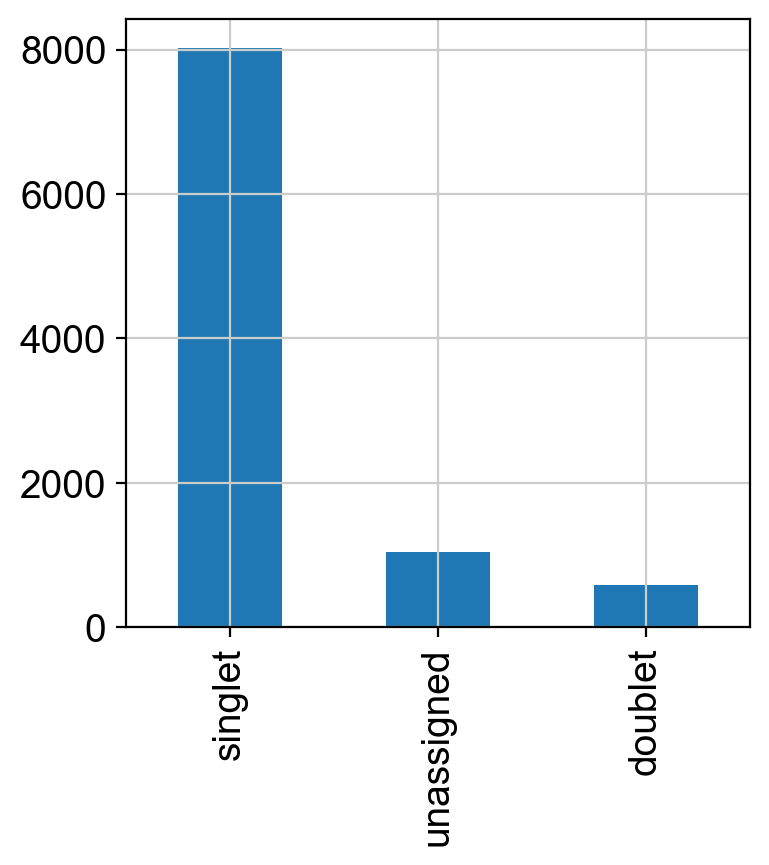

In [16]:
souporcell.status.value_counts().plot(kind='bar')

In [17]:
ad_lung_cst_p.obs['souporcell_status'] = souporcell.status
ad_lung_cst_p.obs['souporcell_assignment'] = souporcell.assignment

ad_lung_cst_p.obs['souporcell_status_ind'] = [f'ind{a}' if s == 'singlet' else s for s, a in zip(ad_lung_cst_p.obs['souporcell_status'], ad_lung_cst_p.obs['souporcell_assignment'])]
ad_lung_cst_p.obs['XIST+'] = (ad_lung_cst_p.obs_vector('XIST') != 0).astype(str)

<AxesSubplot:>

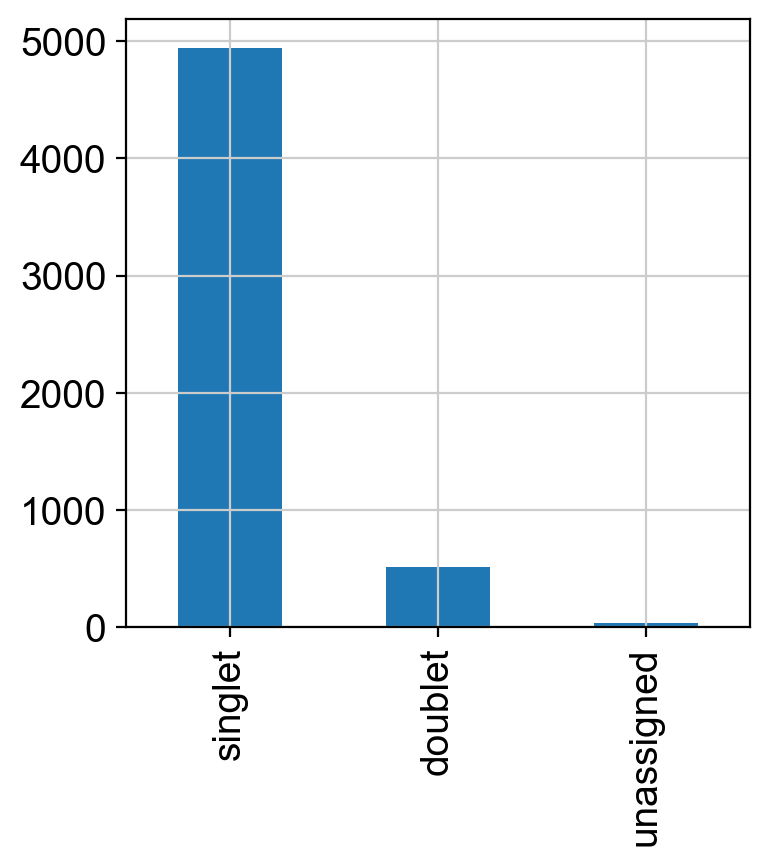

In [18]:
ad_lung_cst_p.obs['souporcell_status'].value_counts().plot(kind='bar')

... storing 'scrublet' as categorical
... storing 'souporcell_status' as categorical
... storing 'souporcell_assignment' as categorical
... storing 'souporcell_status_ind' as categorical
... storing 'XIST+' as categorical


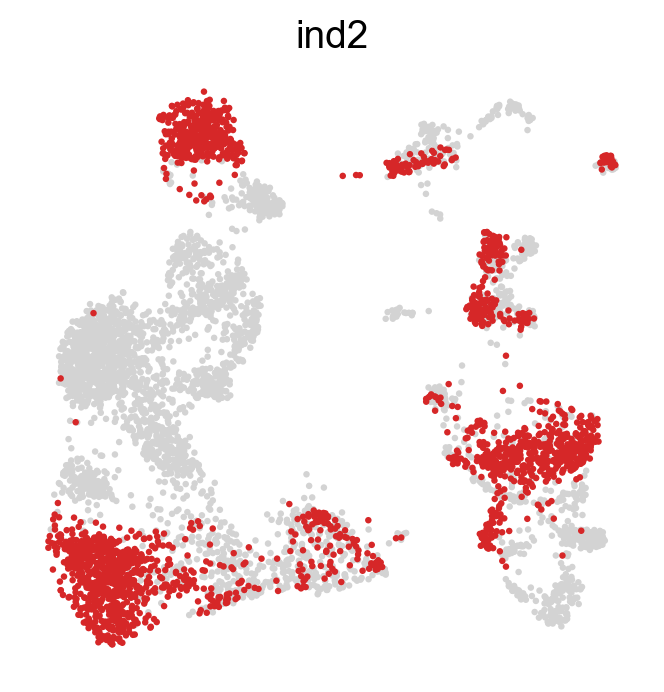

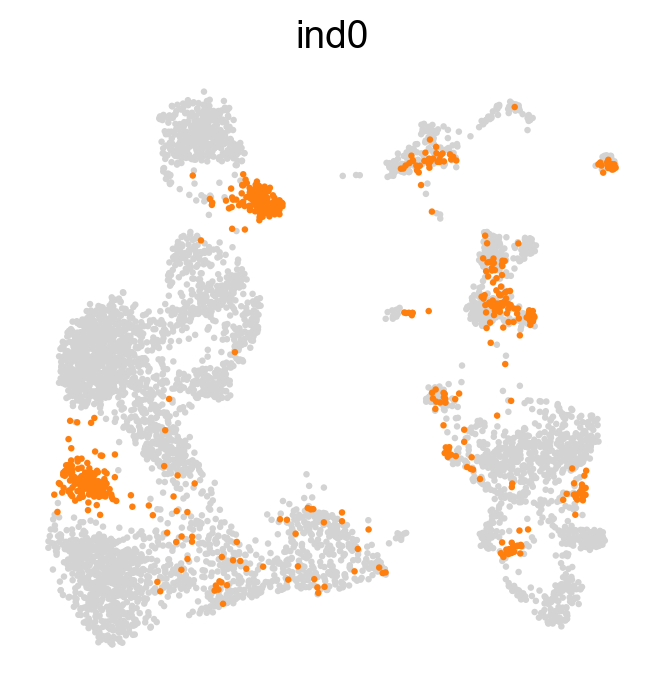

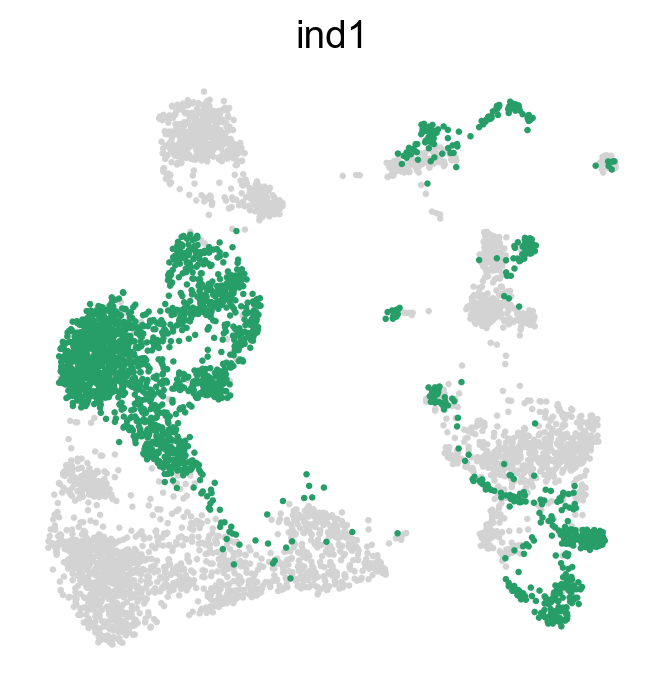

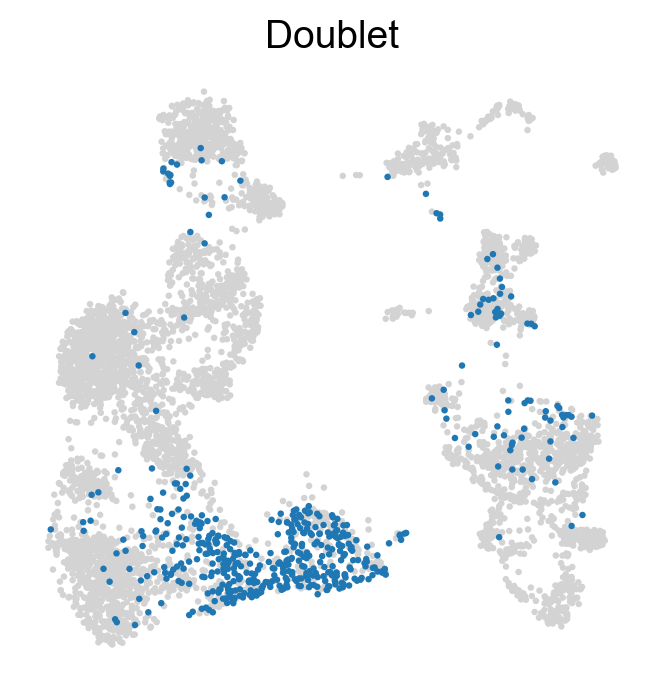

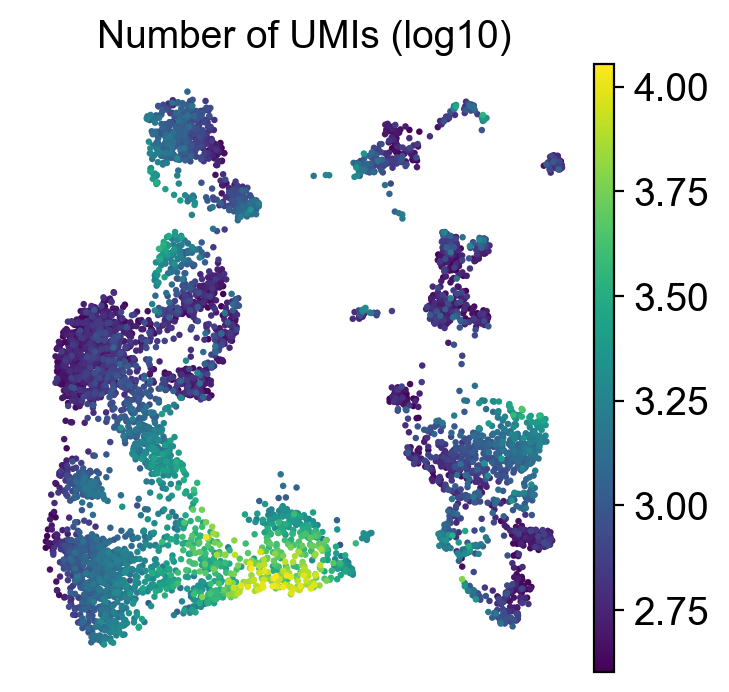

In [19]:
sc.pl.umap(ad_lung_cst_p, color=['souporcell_status_ind'], groups='ind2', legend_loc='none', title='ind2', frameon=False, save='-figure-s1-6-A1.pdf')
sc.pl.umap(ad_lung_cst_p, color=['souporcell_status_ind'], groups='ind0', legend_loc='none', title='ind0', frameon=False, save='-figure-s1-6-A2.pdf')
sc.pl.umap(ad_lung_cst_p, color=['souporcell_status_ind'], groups='ind1', legend_loc='none', title='ind1', frameon=False, save='-figure-s1-6-A3.pdf')
sc.pl.umap(ad_lung_cst_p, color=['souporcell_status_ind'], groups='doublet', legend_loc='none', title='Doublet', frameon=False, save='-figure-s1-6-B.pdf')
sc.pl.umap(ad_lung_cst_p, color='log10_n_umis', frameon=False, save='-figure-s1-6-C.pdf', title='Number of UMIs (log10)')

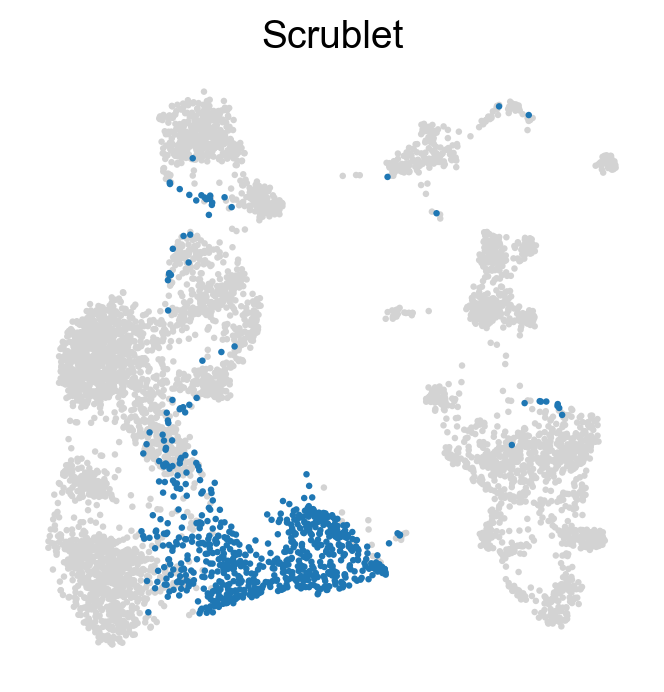

In [20]:
ad_lung_cst_p.uns['scrublet_colors'] = ['#C9C9C9', 'tab:blue']
sc.pl.umap(ad_lung_cst_p, color='scrublet', frameon=False, save='-figure-s1-6-E.pdf', groups=['True'], legend_loc='none', title='Scrublet')

In [21]:
ad = ad_lung_cst_p[~ad_lung_cst_p.obs['souporcell_status_ind'].isin(['doublet', 'unassigned'])].copy()

In [22]:
sc.pp.highly_variable_genes(ad, flavor='seurat_v3', layer='counts', n_top_genes=2000)
sc.pp.pca(ad)
sc.pp.neighbors(ad)
sc.tl.leiden(ad, resolution=2.5)
sc.tl.umap(ad)
sc.tl.dendrogram(ad, groupby='leiden')

## Predict individual labels

In [23]:
%%time

model_lr = LogisticRegression(max_iter=500, penalty='l2', solver='liblinear', C=0.001, class_weight='balanced')
model_lr.fit(ad_lung_cst[:, hvgs].X, ad_lung_cst.obs['Participant ID'])

CPU times: user 358 ms, sys: 4.21 ms, total: 362 ms
Wall time: 360 ms


LogisticRegression(C=0.001, class_weight='balanced', max_iter=500,
                   solver='liblinear')

In [24]:
model_lr.classes_

array(['GTEX-13N11', 'GTEX-15CHR', 'GTEX-1HSMQ'], dtype=object)

## Plot model prediction probabilities

In [27]:
ad_lung_cst_p.obs['individual_predicted_lr'] = model_lr.predict(ad_lung_cst_p[:, hvgs].X)

ad_lung_cst_p.obs['individual_predicted_lr'] = ['unknown' if p<0.6 else l for p, l in zip(model_lr.predict_proba(ad_lung_cst_p[:, hvgs].X).max(1), ad_lung_cst_p.obs['individual_predicted_lr'])]

ad_lung_cst_p.obs['individual_predicted_lr_prob_GTEX-1HSMQ'] = model_lr.predict_proba(ad_lung_cst_p[:, hvgs].X).max(1)
ad_lung_cst_p.obs['individual_predicted_lr_prob_GTEX-1HSMQ'].loc[ad_lung_cst_p.obs.individual_predicted_lr != 'GTEX-1HSMQ'] = np.nan

ad_lung_cst_p.obs['individual_predicted_lr_prob_GTEX-15CHR'] = model_lr.predict_proba(ad_lung_cst_p[:, hvgs].X).max(1)
ad_lung_cst_p.obs['individual_predicted_lr_prob_GTEX-15CHR'].loc[ad_lung_cst_p.obs.individual_predicted_lr != 'GTEX-15CHR'] = np.nan

ad_lung_cst_p.obs['individual_predicted_lr_prob_GTEX-13N11'] = model_lr.predict_proba(ad_lung_cst_p[:, hvgs].X).max(1)
ad_lung_cst_p.obs['individual_predicted_lr_prob_GTEX-13N11'].loc[ad_lung_cst_p.obs.individual_predicted_lr != 'GTEX-13N11'] = np.nan

/home/gokcen/.miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


... storing 'individual_predicted_lr' as categorical


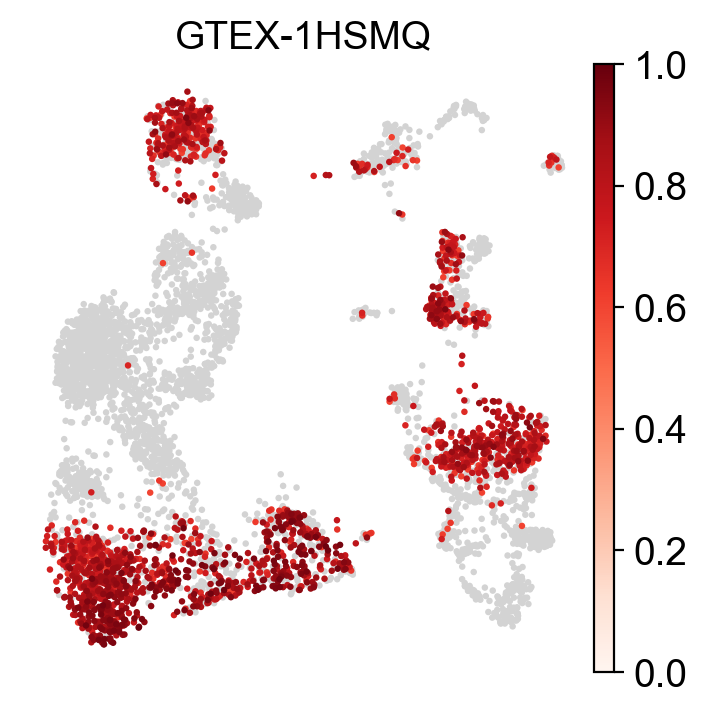

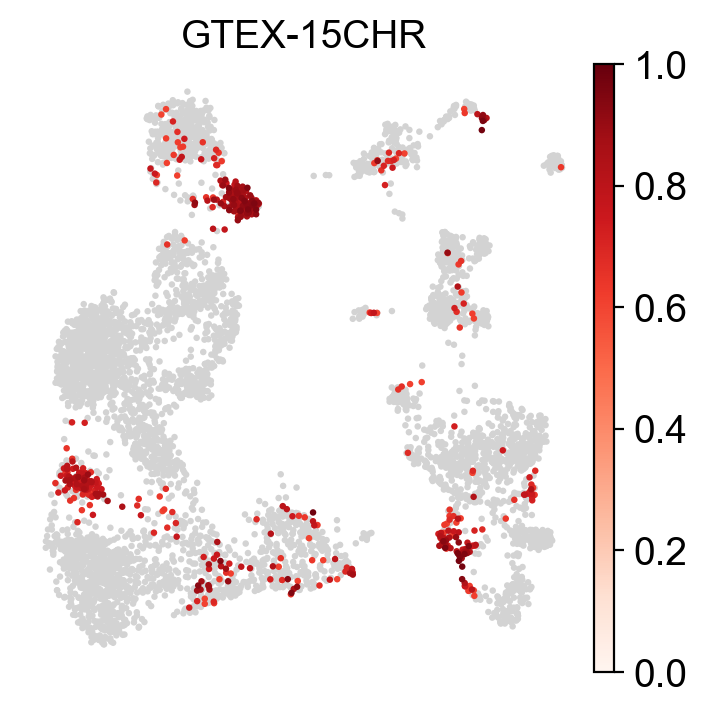

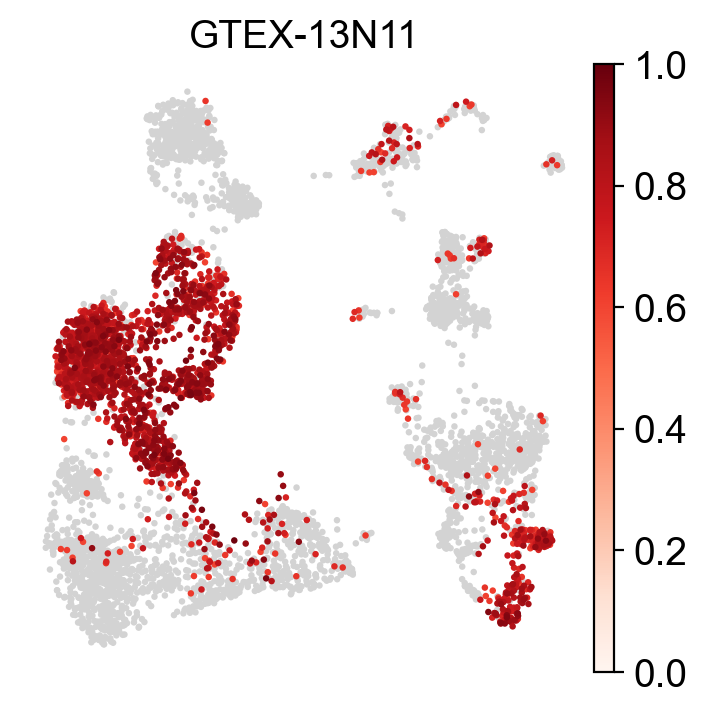

In [28]:
sc.pl.umap(ad_lung_cst_p, color=['individual_predicted_lr_prob_GTEX-1HSMQ'], legend_loc='none', title='GTEX-1HSMQ', frameon=False, cmap='Reds', vmin=0., vmax=1., save='-figure-s1-6-D1.pdf')
sc.pl.umap(ad_lung_cst_p, color=['individual_predicted_lr_prob_GTEX-15CHR'], legend_loc='none', title='GTEX-15CHR', frameon=False, cmap='Reds', vmin=0., vmax=1., save='-figure-s1-6-D2.pdf')
sc.pl.umap(ad_lung_cst_p, color=['individual_predicted_lr_prob_GTEX-13N11'], legend_loc='none', title='GTEX-13N11', frameon=False, cmap='Reds', vmin=0., vmax=1., save='-figure-s1-6-D3.pdf')

## Concordance plots

In [41]:
balanced_accuracy_score(ad_lung_cst_p.obs['souporcell_status_ind'] == 'doublet', ad_lung_cst_p.obs.scrublet == 'True')

0.8385159624899539

In [30]:
df = pd.crosstab(ad_lung_cst_p.obs['souporcell_status_ind'], ad_lung_cst_p.obs['individual_predicted_lr'])
df

individual_predicted_lr  GTEX-1HSMQ  GTEX-13N11  GTEX-15CHR  unknown
souporcell_status_ind                                               
doublet                         251          57          53      151
ind0                             20          14         333      221
ind1                              7        1847          25      391
ind2                           1485          33          67      499
unassigned                        6          22           1        6

In [33]:
pd.crosstab(ad_lung_cst_p.obs['souporcell_status_ind'] == 'doublet', ad_lung_cst_p.obs.scrublet == 'True')

scrublet               False  True 
souporcell_status_ind              
False                   4643    334
True                     131    381

In [42]:
df = pd.crosstab(ad_lung_cst_p.obs['souporcell_status_ind'], ad_lung_cst_p.obs['individual_predicted_lr'])
df.index.name = 'souporcell'
df.columns.name = 'Classifier'
df = df.loc[['ind2', 'ind0', 'ind1'], ['GTEX-1HSMQ', 'GTEX-15CHR', 'GTEX-13N11']]

print(np.diag(df.values).sum() / df.sum().sum())

df = (df.T/df.sum(1)).T * 100

0.9566692769511876


In [43]:
df

Classifier  GTEX-1HSMQ  GTEX-15CHR  GTEX-13N11
souporcell                                    
ind2         93.690852    4.227129    2.082019
ind0          5.449591   90.735695    3.814714
ind1          0.372539    1.330495   98.296966

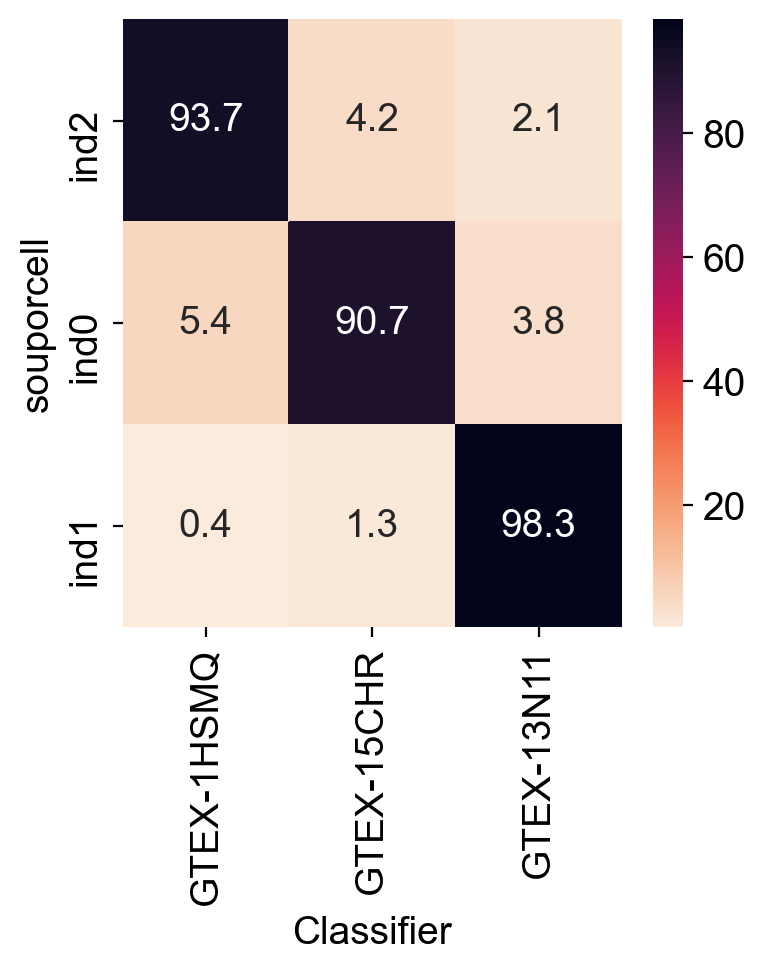

In [44]:
f = sns.heatmap(df, annot=df, fmt='.1f', cmap='rocket_r')

f.figure.savefig('figures/figure-s1-6-F.pdf', bbox_inches='tight')

## Lung TST

### Unpooled

In [45]:
ad_lung_tst = ad_all[(ad_all.obs.tissue == 'lung') & (ad_all.obs.prep == 'TST')].copy()
ad_lung_tst.X = ad_lung_tst.layers['counts'].copy()

sc.pp.normalize_total(ad_lung_tst, target_sum=10000)
sc.pp.log1p(ad_lung_tst)

sc.pp.pca(ad_lung_tst)
sc.pp.neighbors(ad_lung_tst)
sc.tl.umap(ad_lung_tst)

### Demuxlet run

In [46]:
demuxlet = sc.read('final-lungpool-tst.h5ad')
demuxlet.obs.index = [x.split('_')[1] + '-1' for x in demuxlet.obs.index]

demuxlet_orig = sc.read('lungpool-2018_09_19-tst-emptydrops.h5ad')
demuxlet_orig.obs.index = [x.split('_')[1] + '-1' for x in demuxlet_orig.obs.index]

### Pooled

In [47]:
ad_lung_tst

AnnData object with n_obs × n_vars = 11983 × 33694
    obs: 'n_genes', 'fpr', 'tissue', 'prep', 'individual', 'nGenes', 'nUMIs', 'PercentMito', 'PercentRibo', 'Age_bin', 'Sex', 'Sample ID', 'Participant ID', 'Container', 'Sample ID short', 'RIN score from PAXgene tissue Aliquot', 'RIN score from Frozen tissue Aliquot', 'Age', 'BMI', 'Race/Ethnicity', 'Autolysis Score', 'Sample Ischemic Time (mins)', 'Tissue Site Detail', 'scrublet', 'scrublet_score', 'barcode', 'batch', 'n_counts', 'tissue-individual-prep', 'Broad cell type', 'Granular cell type', 'batch_triplet', 'introns', 'junctions', 'exons', 'sense', 'antisense', 'intergenic', 'batch-barcode', 'exon_ratio', 'intron_ratio', 'junction_ratio', 'log10_nUMIs', 'leiden', 'leiden_tissue', 'Tissue composition', 'Cell types level 2', 'Cell types level 3', 'Broad cell type numbers', 'Broad cell type (numbers)', 'Tissue', 'channel', 'ischemic_time', 'Participant_ID', 'Sample_ID'
    var: 'gene_ids', 'Chromosome', 'Source', 'Start', 'End', 'S

In [48]:
ad_lung_tst_p = sc.read_10x_h5('pool_lung_tst_out_FPR_0.1_filtered.h5')
sc.pp.filter_cells(ad_lung_tst_p, min_genes=200)
sc.pp.filter_cells(ad_lung_tst_p, max_genes=5000)
sc.pp.filter_cells(ad_lung_tst_p, min_counts=400)

ad_lung_tst_p.var_names_make_unique()
ad_lung_tst_p = ad_lung_tst_p[:, ad_lung_tst.var_names.tolist()].copy()
ad_lung_tst_p.layers['counts'] = ad_lung_tst_p.X.copy()
ad_lung_tst_p.obs['log10_n_umis'] = np.log10(ad_lung_tst_p.obs.n_counts)

sc.pp.normalize_total(ad_lung_tst_p, target_sum=10000)
sc.pp.log1p(ad_lung_tst_p)

sc.pp.pca(ad_lung_tst_p)
sc.pp.neighbors(ad_lung_tst_p)
sc.tl.umap(ad_lung_tst_p)
sc.tl.leiden(ad_lung_tst_p)

ad_lung_tst_p.layers['scaled'] = ad_lung_tst_p.X.copy()
sc.pp.scale(ad_lung_tst_p, layer='scaled')

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [49]:
df = sc.pp.highly_variable_genes(ad_lung_tst, n_top_genes=2000, flavor='seurat_v3', inplace=False, layer='counts')
hvgs = df.index[df.highly_variable]

df = sc.pp.highly_variable_genes(ad_lung_tst_p, n_top_genes=2000, flavor='seurat_v3', inplace=False, layer='counts')
hvgs_p = df.index[df.highly_variable]

In [50]:
hvgs = sorted(list(set(hvgs) & set(hvgs_p)))
hvgs.remove('RBFOX1')
len(hvgs)

1364

## Doublet calling

In [51]:
scr = Scrublet(ad_lung_tst_p.layers['counts'])

scores, scrublets = scr.scrub_doublets(n_prin_comps=50, log_transform=True)
ad_lung_tst_p.obs['scrublet_score'] = scores
ad_lung_tst_p.obs['scrublet'] = scrublets.astype(str)

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.44
Detected doublet rate = 2.1%
Estimated detectable doublet fraction = 36.5%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 5.7%
Elapsed time: 8.3 seconds


## Read souporcell results

In [52]:
souporcell = pd.read_table('lung_tst_souporcell.tsv', index_col=0)
souporcell.index.name = None

<AxesSubplot:>

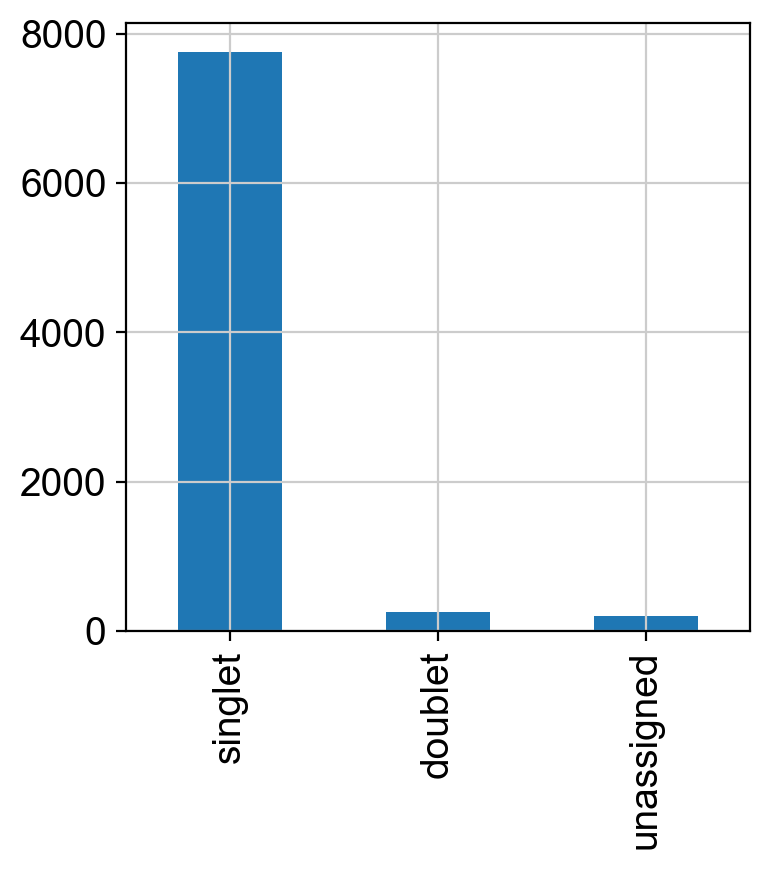

In [53]:
souporcell.status.value_counts().plot(kind='bar')

In [54]:
ad_lung_tst_p.obs['souporcell_status'] = souporcell.status
ad_lung_tst_p.obs['souporcell_assignment'] = souporcell.assignment

ad_lung_tst_p.obs['souporcell_status_ind'] = [f'ind{a}' if s == 'singlet' else s for s, a in zip(ad_lung_tst_p.obs['souporcell_status'], ad_lung_tst_p.obs['souporcell_assignment'])]

ad_lung_tst_p.obs['individual'] = demuxlet_orig.obs.individual
ad_lung_tst_p.obs['individual_filtered'] = demuxlet.obs.individual

ad_lung_tst_p.obs['Broad cell type'] = demuxlet.obs['Broad cell type']

ad_lung_tst_p.obs['XIST+'] = (ad_lung_tst_p.obs_vector('XIST') != 0).astype(str)

<AxesSubplot:>

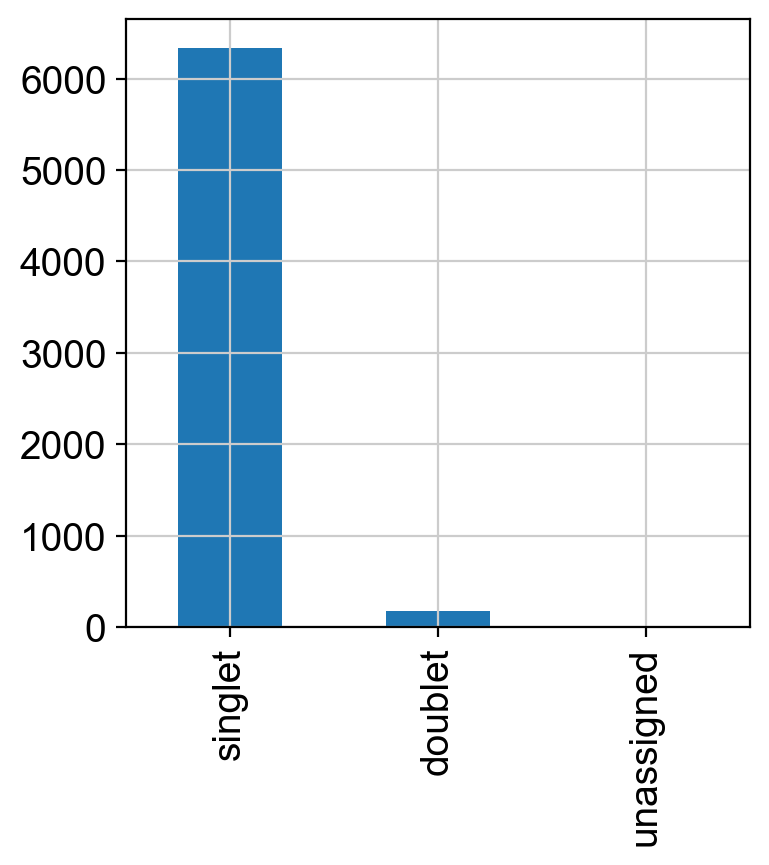

In [55]:
ad_lung_tst_p.obs['souporcell_status'].value_counts().plot(kind='bar')

... storing 'scrublet' as categorical
... storing 'souporcell_status' as categorical
... storing 'souporcell_assignment' as categorical
... storing 'souporcell_status_ind' as categorical
... storing 'XIST+' as categorical


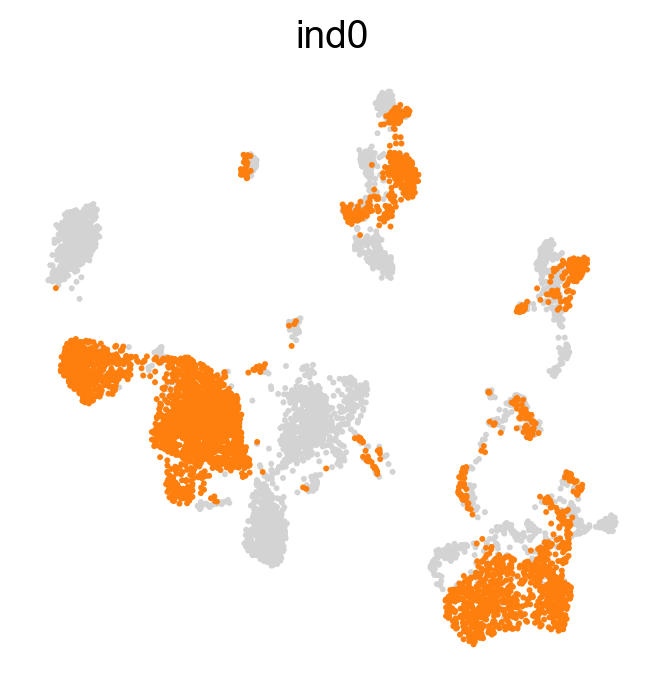

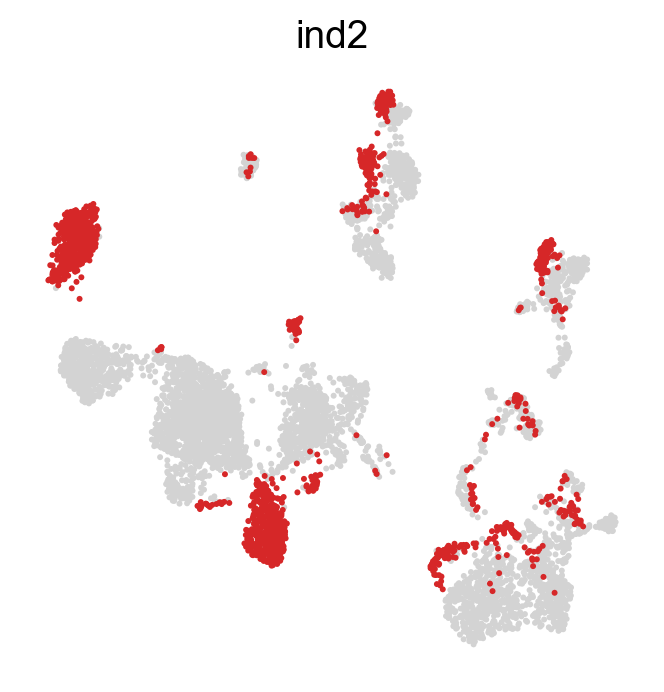

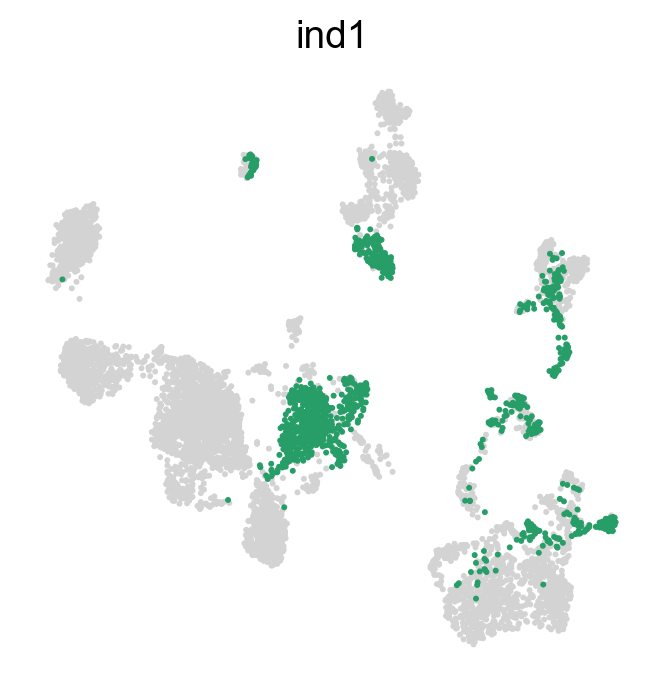

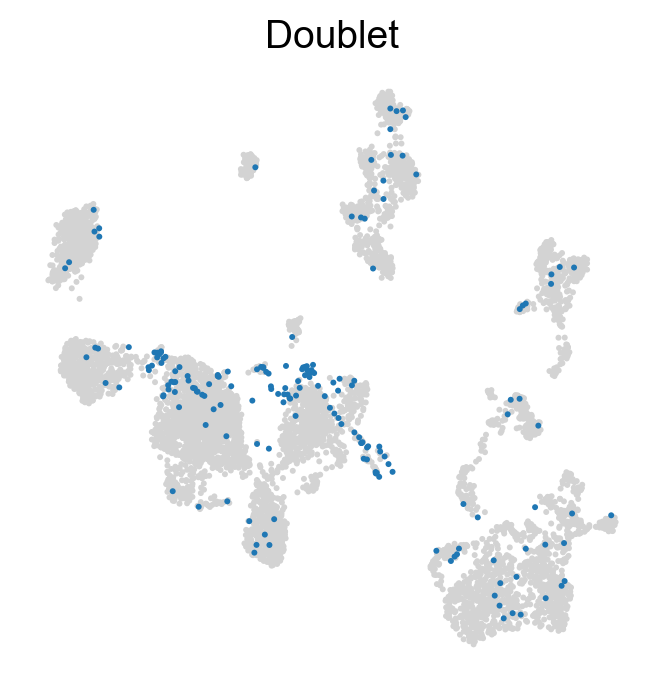

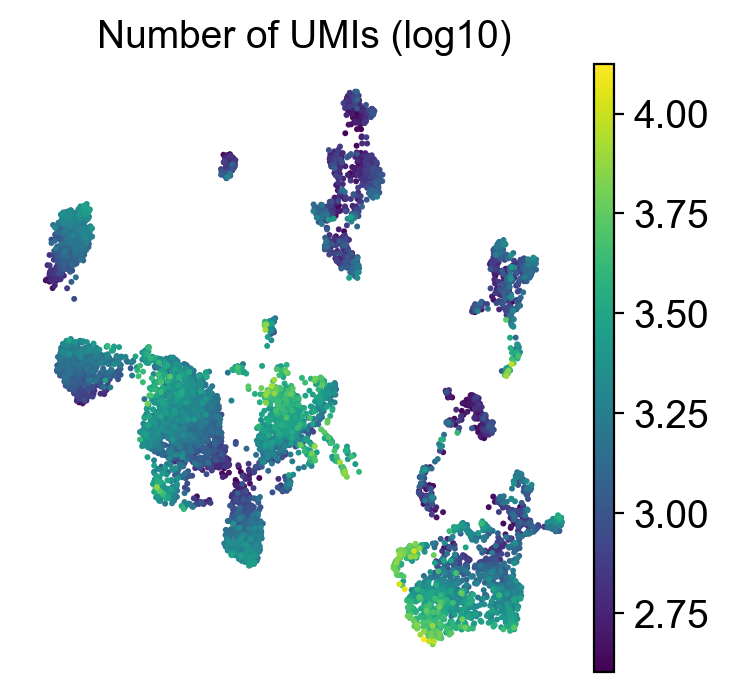

In [56]:
sc.pl.umap(ad_lung_tst_p, color=['souporcell_status_ind'], groups='ind0', legend_loc='none', title='ind0', frameon=False, save='-figure-s1-6-G1.pdf')
sc.pl.umap(ad_lung_tst_p, color=['souporcell_status_ind'], groups='ind2', legend_loc='none', title='ind2', frameon=False, save='-figure-s1-6-G2.pdf')
sc.pl.umap(ad_lung_tst_p, color=['souporcell_status_ind'], groups='ind1', legend_loc='none', title='ind1', frameon=False, save='-figure-s1-6-G3.pdf')
sc.pl.umap(ad_lung_tst_p, color=['souporcell_status_ind'], groups='doublet', legend_loc='none', title='Doublet', frameon=False, save='-figure-s1-6-H.pdf')
sc.pl.umap(ad_lung_tst_p, color='log10_n_umis', title='Number of UMIs (log10)', frameon=False, save='-figure-s1-6-I.pdf')

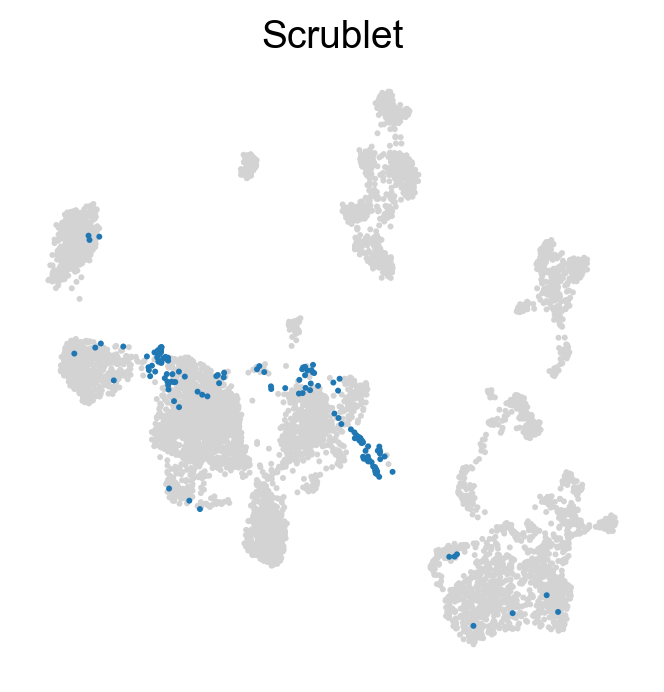

In [57]:
ad_lung_tst_p.uns['scrublet_colors'] = ['tab:blue','tab:blue']
sc.pl.umap(ad_lung_tst_p, color='scrublet', frameon=False, save='-figure-s1-6-K.pdf', groups=['True'], legend_loc='none', title='Scrublet')

## Predict individual labels

In [58]:
%%time

model_lr = LogisticRegression(max_iter=500, class_weight='balanced', penalty='l2', C=0.0005, solver='liblinear')

model_lr.fit(ad_lung_tst[:, hvgs].X, ad_lung_tst.obs['Participant ID'])

CPU times: user 694 ms, sys: 117 µs, total: 694 ms
Wall time: 692 ms


LogisticRegression(C=0.0005, class_weight='balanced', max_iter=500,
                   solver='liblinear')

In [59]:
model_lr.classes_

array(['GTEX-13N11', 'GTEX-15CHR', 'GTEX-1HSMQ'], dtype=object)

## Plot model prediction probabilities

In [63]:
ad_lung_tst_p.obs['individual_predicted_lr'] = model_lr.predict(ad_lung_tst_p[:, hvgs].X)

ad_lung_tst_p.obs['individual_predicted_lr'] = ['unknown' if p<0.6 else l for p, l in zip(model_lr.predict_proba(ad_lung_tst_p[:, hvgs].X).max(1), ad_lung_tst_p.obs['individual_predicted_lr'])]

ad_lung_tst_p.obs['individual_predicted_lr_prob_GTEX-1HSMQ'] = model_lr.predict_proba(ad_lung_tst_p[:, hvgs].X).max(1)
ad_lung_tst_p.obs['individual_predicted_lr_prob_GTEX-1HSMQ'].loc[ad_lung_tst_p.obs.individual_predicted_lr != 'GTEX-1HSMQ'] = np.nan

ad_lung_tst_p.obs['individual_predicted_lr_prob_GTEX-15CHR'] = model_lr.predict_proba(ad_lung_tst_p[:, hvgs].X).max(1)
ad_lung_tst_p.obs['individual_predicted_lr_prob_GTEX-15CHR'].loc[ad_lung_tst_p.obs.individual_predicted_lr != 'GTEX-15CHR'] = np.nan

ad_lung_tst_p.obs['individual_predicted_lr_prob_GTEX-13N11'] = model_lr.predict_proba(ad_lung_tst_p[:, hvgs].X).max(1)
ad_lung_tst_p.obs['individual_predicted_lr_prob_GTEX-13N11'].loc[ad_lung_tst_p.obs.individual_predicted_lr != 'GTEX-13N11'] = np.nan

/home/gokcen/.miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


... storing 'individual_predicted_lr' as categorical


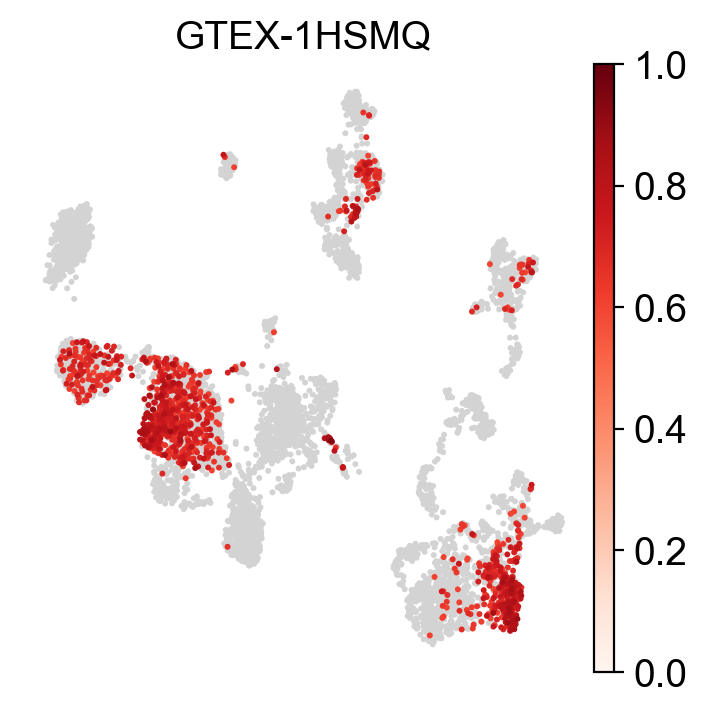

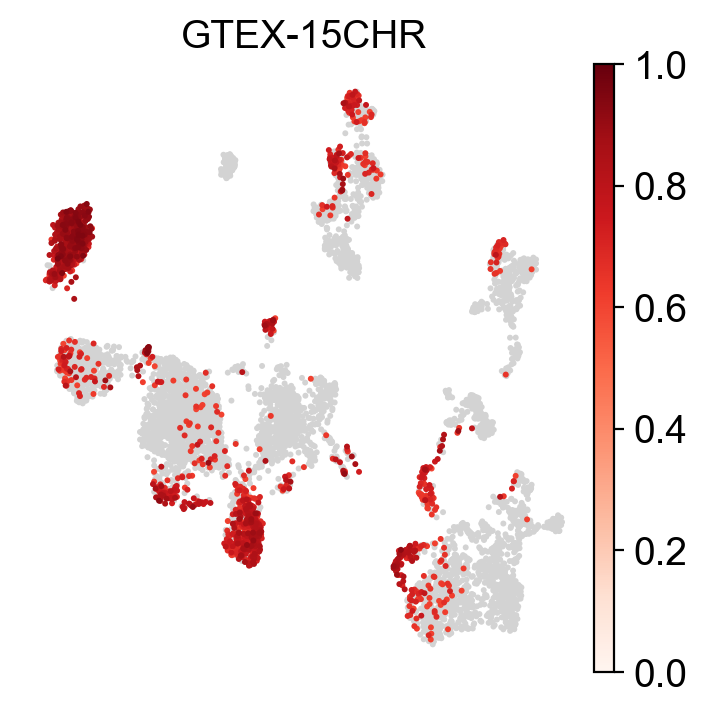

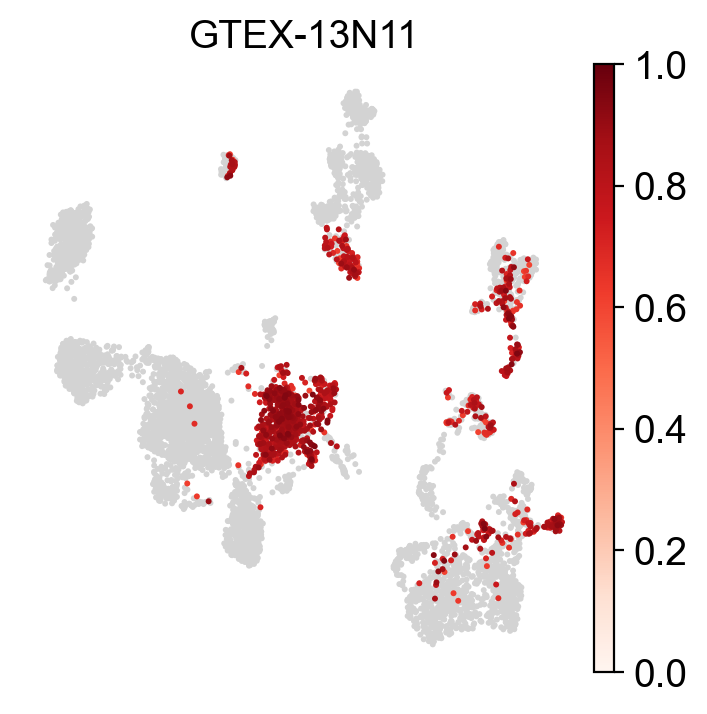

In [64]:
sc.pl.umap(ad_lung_tst_p, color=['individual_predicted_lr_prob_GTEX-1HSMQ'], legend_loc='none', title='GTEX-1HSMQ', frameon=False, cmap='Reds', vmin=0., vmax=1., save='-figure-s1-6-J1.pdf')
sc.pl.umap(ad_lung_tst_p, color=['individual_predicted_lr_prob_GTEX-15CHR'], legend_loc='none', title='GTEX-15CHR', frameon=False, cmap='Reds', vmin=0., vmax=1., save='-figure-s1-6-J2.pdf')
sc.pl.umap(ad_lung_tst_p, color=['individual_predicted_lr_prob_GTEX-13N11'], legend_loc='none', title='GTEX-13N11', frameon=False, cmap='Reds', vmin=0., vmax=1., save='-figure-s1-6-J3.pdf')

## Concordance plots

In [66]:
balanced_accuracy_score(ad_lung_tst_p.obs['souporcell_status_ind'] == 'doublet', ad_lung_tst_p.obs.scrublet == 'True')

0.6654393549538724

In [67]:
df = pd.crosstab(ad_lung_tst_p.obs['souporcell_status_ind'], ad_lung_tst_p.obs['individual_predicted_lr'])
df.index.name = 'souporcell'
df.columns.name = 'Classifier'
df = df.loc[['ind0', 'ind2', 'ind1'], ['GTEX-1HSMQ', 'GTEX-15CHR', 'GTEX-13N11']]

print(np.diag(df.values).sum()/df.sum().sum())

df = (df.T/df.sum(1)).T * 100

0.8952324896998234


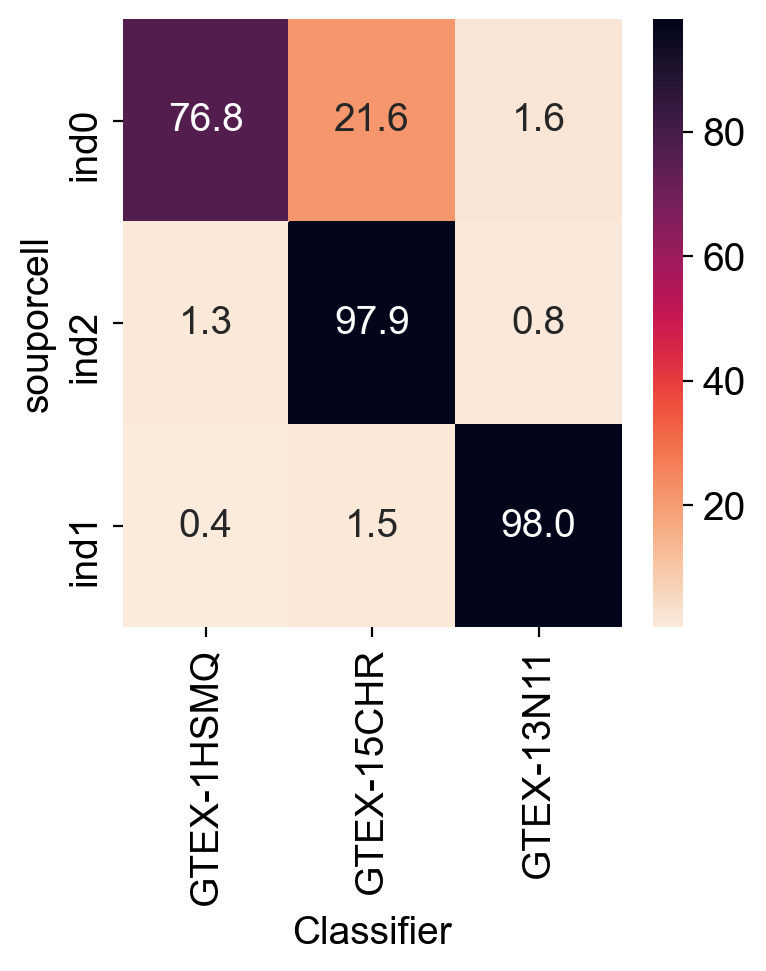

In [68]:
f = sns.heatmap(df, annot=df, fmt='.1f', cmap='rocket_r')
f.figure.savefig('figures/figure-s1-6-L.pdf', bbox_inches='tight')

## Prostate CST

### Unpooled

In [69]:
#ad_prostate_cst = ad_all[(ad_all.obs.tissue == 'prostate') & (ad_all.obs.prep == 'CST')].copy()
#ad_prostate_cst = ad_all[(ad_all.obs.tissue == 'prostate')].copy()
ad_prostate_cst = ad_all[(ad_all.obs.tissue == 'prostate') & (ad_all.obs.prep == 'CST') & (ad_all.obs['Participant ID'] != 'GTEX-1HSMQ')].copy()

ad_prostate_cst.X = ad_prostate_cst.layers['counts'].copy()

sc.pp.normalize_total(ad_prostate_cst, target_sum=10000)
sc.pp.log1p(ad_prostate_cst)

sc.pp.pca(ad_prostate_cst)
sc.pp.neighbors(ad_prostate_cst)
sc.tl.umap(ad_prostate_cst)

ad_prostate_cst

AnnData object with n_obs × n_vars = 7902 × 33694
    obs: 'n_genes', 'fpr', 'tissue', 'prep', 'individual', 'nGenes', 'nUMIs', 'PercentMito', 'PercentRibo', 'Age_bin', 'Sex', 'Sample ID', 'Participant ID', 'Container', 'Sample ID short', 'RIN score from PAXgene tissue Aliquot', 'RIN score from Frozen tissue Aliquot', 'Age', 'BMI', 'Race/Ethnicity', 'Autolysis Score', 'Sample Ischemic Time (mins)', 'Tissue Site Detail', 'scrublet', 'scrublet_score', 'barcode', 'batch', 'n_counts', 'tissue-individual-prep', 'Broad cell type', 'Granular cell type', 'batch_triplet', 'introns', 'junctions', 'exons', 'sense', 'antisense', 'intergenic', 'batch-barcode', 'exon_ratio', 'intron_ratio', 'junction_ratio', 'log10_nUMIs', 'leiden', 'leiden_tissue', 'Tissue composition', 'Cell types level 2', 'Cell types level 3', 'Broad cell type numbers', 'Broad cell type (numbers)', 'Tissue', 'channel', 'ischemic_time', 'Participant_ID', 'Sample_ID'
    var: 'gene_ids', 'Chromosome', 'Source', 'Start', 'End', 'St

### Pooled

In [70]:
ad_prostate_cst_p = sc.read_10x_h5('pool_prostate_cst_out_FPR_0.1_filtered.h5')
sc.pp.filter_cells(ad_prostate_cst_p, min_genes=200)
sc.pp.filter_cells(ad_prostate_cst_p, max_genes=5000)
sc.pp.filter_cells(ad_prostate_cst_p, min_counts=400)

ad_prostate_cst_p.var_names_make_unique()
ad_prostate_cst_p = ad_prostate_cst_p[:, ad_prostate_cst.var_names.tolist()].copy()
ad_prostate_cst_p.layers['counts'] = ad_prostate_cst_p.X.copy()
ad_prostate_cst_p.obs['log10_n_umis'] = np.log10(ad_prostate_cst_p.obs.n_counts)

sc.pp.normalize_total(ad_prostate_cst_p, target_sum=10000)
sc.pp.log1p(ad_prostate_cst_p)

sc.pp.pca(ad_prostate_cst_p)
sc.pp.neighbors(ad_prostate_cst_p)
sc.tl.umap(ad_prostate_cst_p)
sc.tl.leiden(ad_prostate_cst_p)

ad_prostate_cst_p.layers['scaled'] = ad_prostate_cst_p.X.copy()
sc.pp.scale(ad_prostate_cst_p, layer='scaled')

ad_prostate_cst_p

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 1713 × 33694
    obs: 'n_genes', 'n_counts', 'log10_n_umis', 'leiden'
    var: 'gene_ids', 'mean', 'std'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'scaled'
    obsp: 'distances', 'connectivities'

In [71]:
df = sc.pp.highly_variable_genes(ad_prostate_cst, n_top_genes=2000, flavor='seurat_v3', inplace=False, layer='counts')
hvgs = df.index[df.highly_variable]

df = sc.pp.highly_variable_genes(ad_prostate_cst_p, n_top_genes=2000, flavor='seurat_v3', inplace=False, layer='counts')
hvgs_p = df.index[df.highly_variable]

In [72]:
hvgs = sorted(list(set(hvgs) & set(hvgs_p)))
#hvgs.remove('ELL2')
len(hvgs)

1101

## Doublet calling

In [73]:
scr = Scrublet(ad_prostate_cst_p.layers['counts'])

scores, scrublets = scr.scrub_doublets(n_prin_comps=50, log_transform=True)
ad_prostate_cst_p.obs['scrublet_score'] = scores
ad_prostate_cst_p.obs['scrublet'] = scrublets.astype(str)

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.60
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 0.8%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 6.9%
Elapsed time: 0.9 seconds


## Read souporcell results

In [74]:
souporcell = pd.read_table('prostate_cst_souporcell.tsv', index_col=0)
souporcell.index.name = None

<AxesSubplot:>

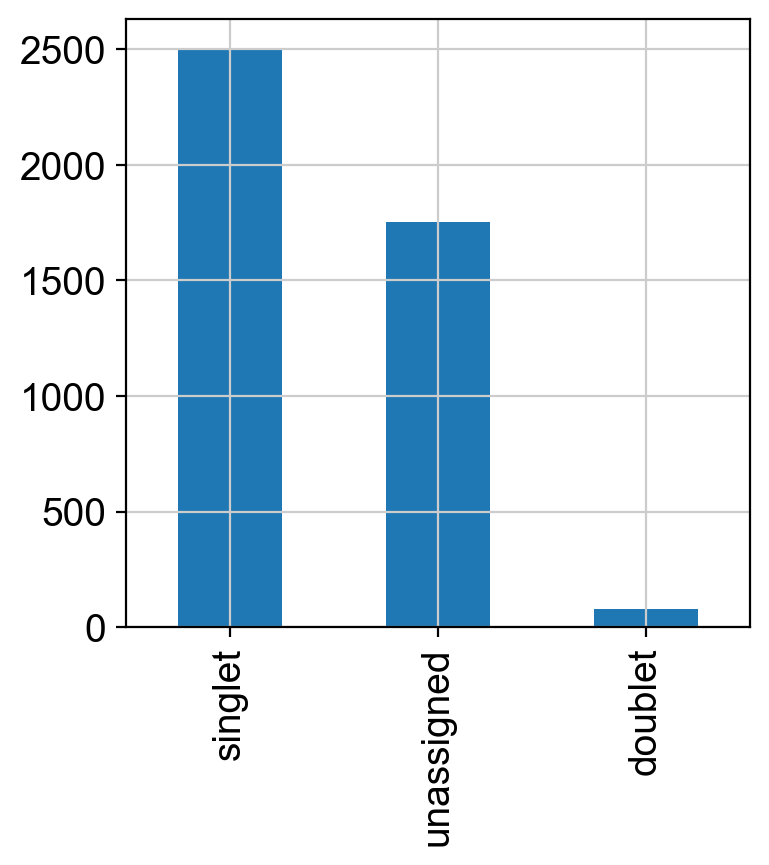

In [75]:
souporcell.status.value_counts().plot(kind='bar')

In [76]:
ad_prostate_cst_p.obs['souporcell_status'] = souporcell.status
ad_prostate_cst_p.obs['souporcell_assignment'] = souporcell.assignment
ad_prostate_cst_p.obs['souporcell_status_ind'] = [f'ind{a}' if s == 'singlet' else s for s, a in zip(ad_prostate_cst_p.obs['souporcell_status'], ad_prostate_cst_p.obs['souporcell_assignment'])]

ad_prostate_cst_p.obs['XIST+'] = (ad_prostate_cst_p.obs_vector('XIST') != 0).astype(str)

<AxesSubplot:>

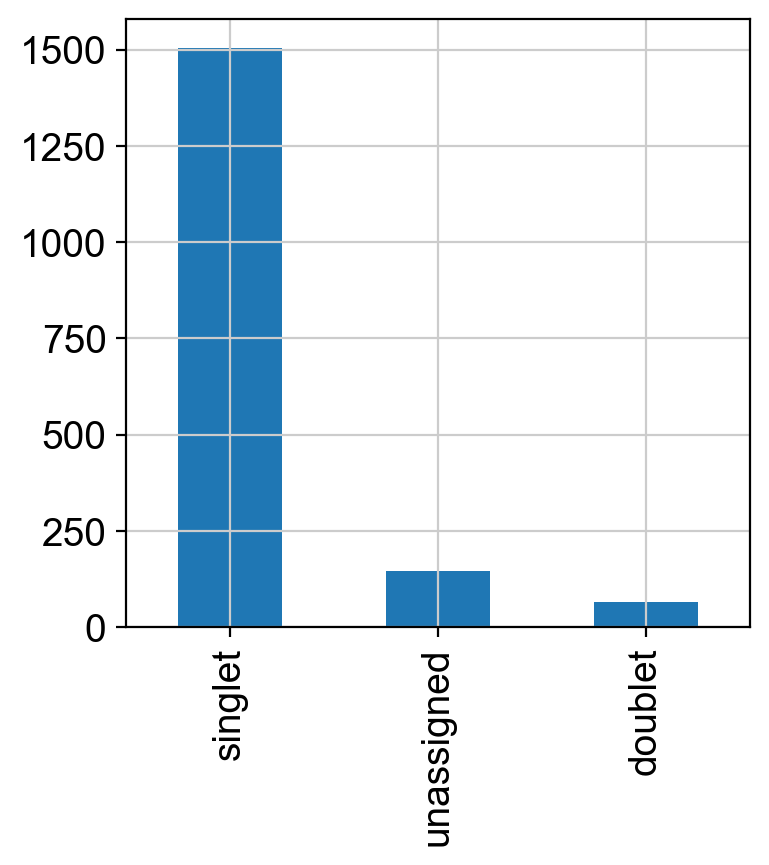

In [77]:
ad_prostate_cst_p.obs['souporcell_status'].value_counts().plot(kind='bar')

In [78]:
ad_prostate_cst_p.obs.souporcell_status.value_counts(normalize=True)

singlet       0.877992
unassigned    0.084647
doublet       0.037361
Name: souporcell_status, dtype: float64

In [79]:
ad_prostate_cst_p.obs['scrublet'].value_counts(normalize=True)

False    0.999416
True     0.000584
Name: scrublet, dtype: float64

... storing 'scrublet' as categorical
... storing 'souporcell_status' as categorical
... storing 'souporcell_assignment' as categorical
... storing 'souporcell_status_ind' as categorical
... storing 'XIST+' as categorical


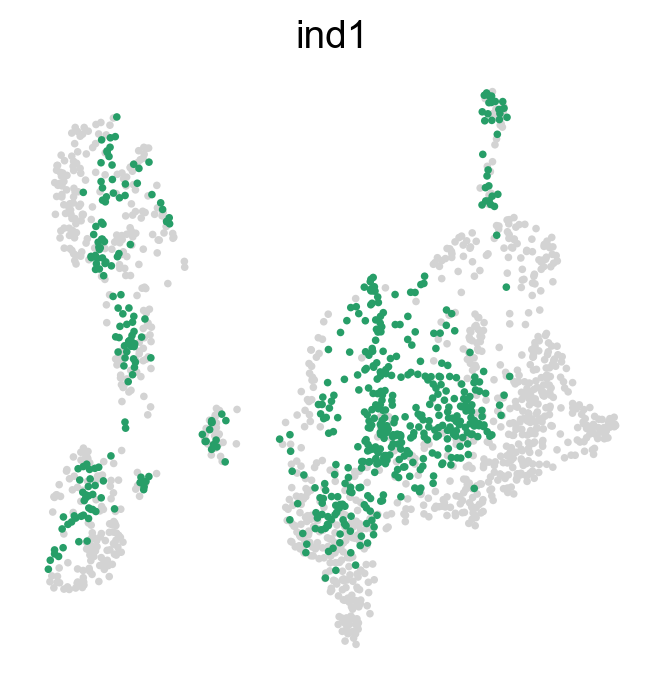

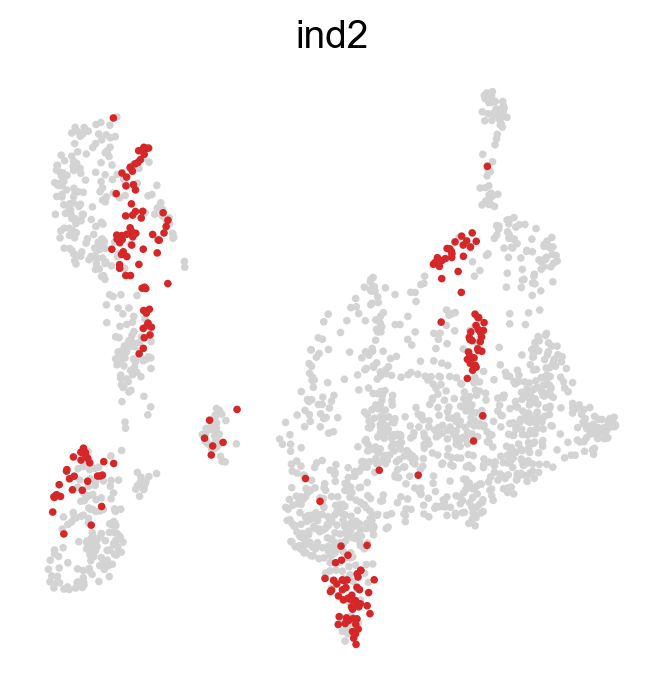

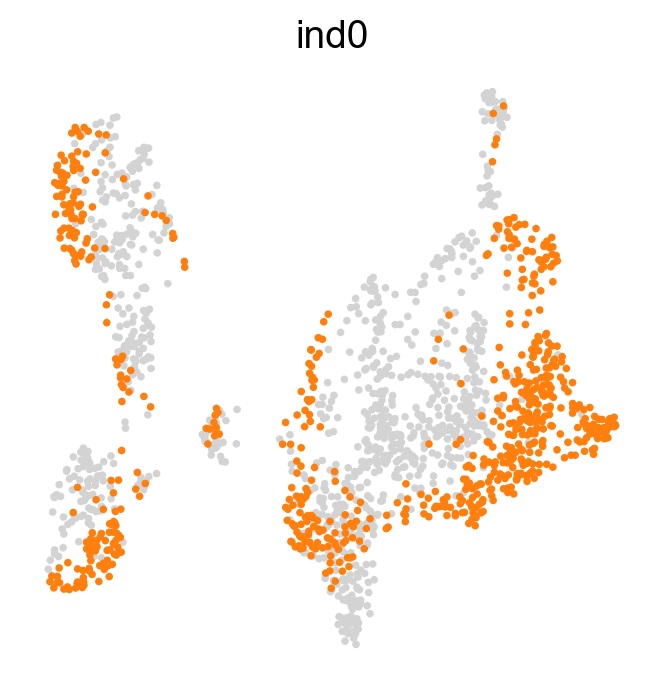

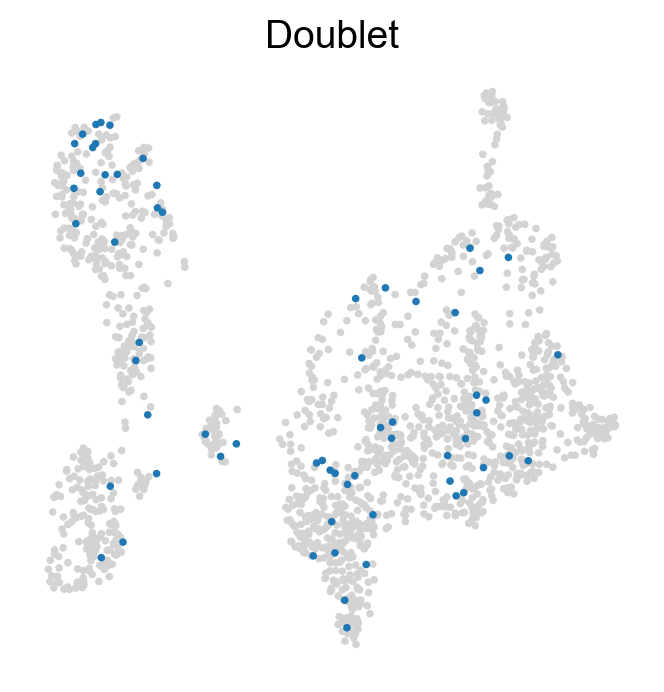

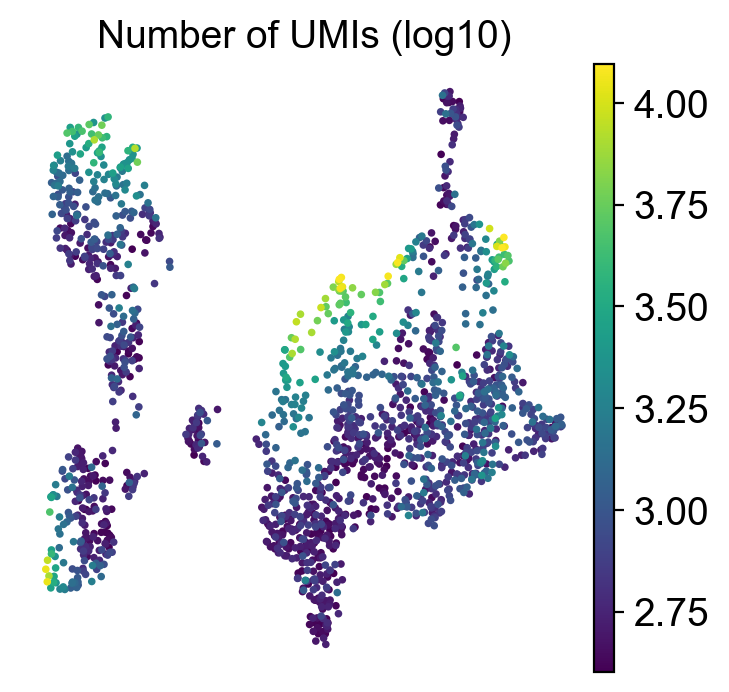

In [80]:
sc.pl.umap(ad_prostate_cst_p, color=['souporcell_status_ind'], groups='ind1', legend_loc='none', title='ind1', frameon=False, size=30, save='-figure-s1-6-M1.pdf')
sc.pl.umap(ad_prostate_cst_p, color=['souporcell_status_ind'], groups='ind2', legend_loc='none', title='ind2', frameon=False, size=30, save='-figure-s1-6-M2.pdf')
sc.pl.umap(ad_prostate_cst_p, color=['souporcell_status_ind'], groups='ind0', legend_loc='none', title='ind0', frameon=False, size=30, save='-figure-s1-6-M3.pdf')
sc.pl.umap(ad_prostate_cst_p, color=['souporcell_status_ind'], groups='doublet', legend_loc='none', title='Doublet', frameon=False, size=30, save='-figure-s1-6-N.pdf')
sc.pl.umap(ad_prostate_cst_p, color='log10_n_umis', frameon=False, size=30, title='Number of UMIs (log10)', save='-figure-s1-6-O.pdf')

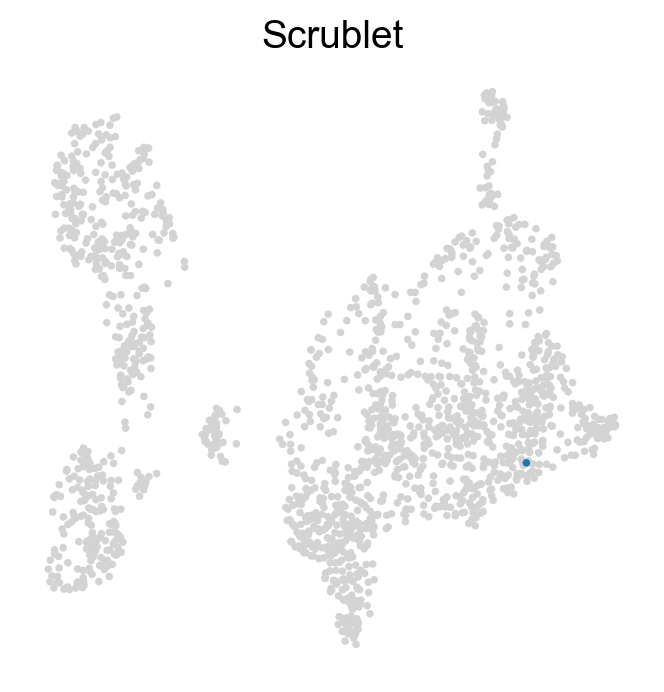

In [81]:
ad_prostate_cst_p.uns['scrublet_colors'] = ['tab:blue','tab:blue']
sc.pl.umap(ad_prostate_cst_p, color='scrublet', frameon=False, save='-figure-s1-6-Q.pdf', size=30, groups=['True'], legend_loc='none', title='Scrublet')

## Predict individual labels

In [82]:
%%time

model_lr = LogisticRegression(max_iter=500, penalty='l2', solver='liblinear', C=0.001, class_weight='balanced')
model_lr.fit(ad_prostate_cst[:, hvgs].X, ad_prostate_cst.obs['Participant ID'])

CPU times: user 335 ms, sys: 3.93 ms, total: 339 ms
Wall time: 337 ms


LogisticRegression(C=0.001, class_weight='balanced', max_iter=500,
                   solver='liblinear')

In [83]:
model_lr.classes_

array(['GTEX-12BJ1', 'GTEX-15CHR', 'GTEX-1I1GU'], dtype=object)

## Plot model prediction probabilities

In [87]:
ad_prostate_cst_p.obs['individual_predicted_lr'] = model_lr.predict(ad_prostate_cst_p[:, hvgs].X)

ad_prostate_cst_p.obs['individual_predicted_lr'] = ['unknown' if p<0.6 else l for p, l in zip(model_lr.predict_proba(ad_prostate_cst_p[:, hvgs].X).max(1), ad_prostate_cst_p.obs['individual_predicted_lr'])]

ad_prostate_cst_p.obs['individual_predicted_lr_prob_GTEX-12BJ1'] = model_lr.predict_proba(ad_prostate_cst_p[:, hvgs].X).max(1)
ad_prostate_cst_p.obs['individual_predicted_lr_prob_GTEX-12BJ1'].loc[ad_prostate_cst_p.obs.individual_predicted_lr != 'GTEX-12BJ1'] = np.nan

ad_prostate_cst_p.obs['individual_predicted_lr_prob_GTEX-15CHR'] = model_lr.predict_proba(ad_prostate_cst_p[:, hvgs].X).max(1)
ad_prostate_cst_p.obs['individual_predicted_lr_prob_GTEX-15CHR'].loc[ad_prostate_cst_p.obs.individual_predicted_lr != 'GTEX-15CHR'] = np.nan

ad_prostate_cst_p.obs['individual_predicted_lr_prob_GTEX-1I1GU'] = model_lr.predict_proba(ad_prostate_cst_p[:, hvgs].X).max(1)
ad_prostate_cst_p.obs['individual_predicted_lr_prob_GTEX-1I1GU'].loc[ad_prostate_cst_p.obs.individual_predicted_lr != 'GTEX-1I1GU'] = np.nan

/home/gokcen/.miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


... storing 'individual_predicted_lr' as categorical


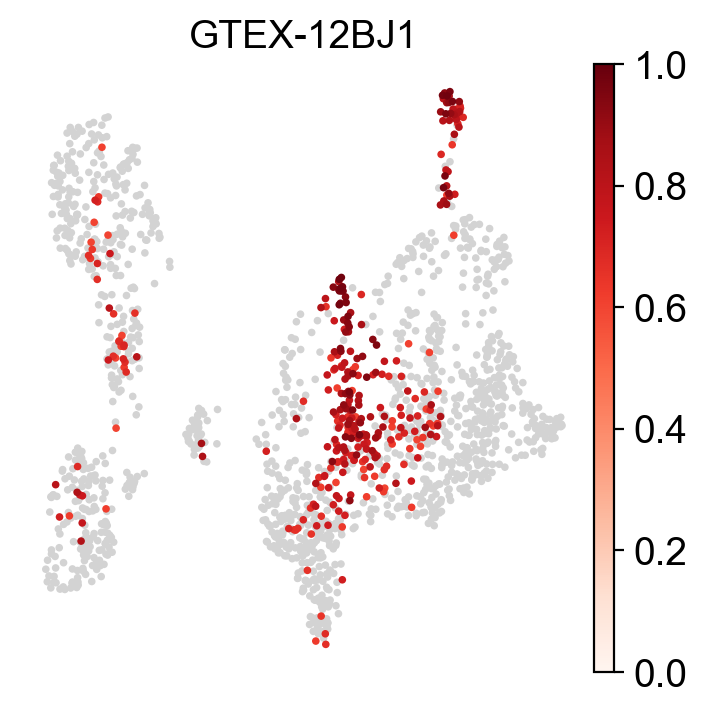

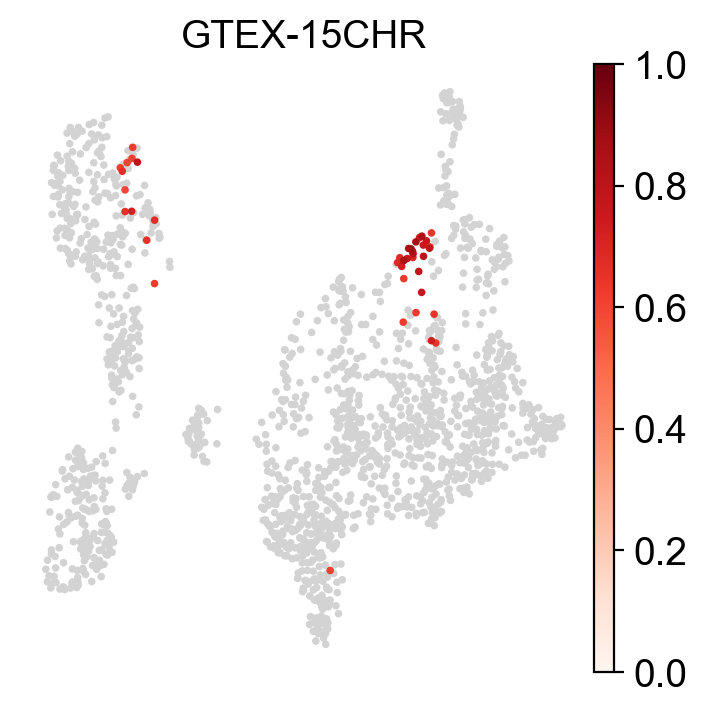

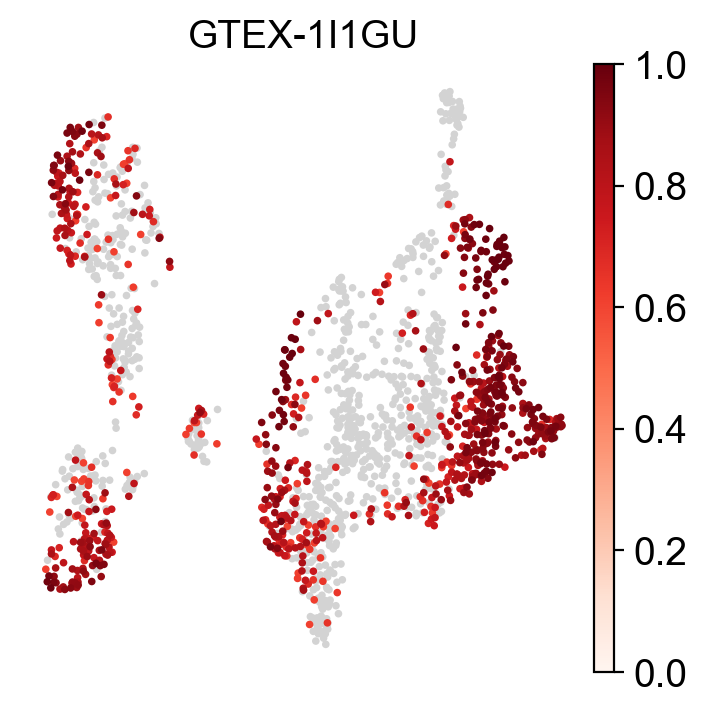

In [88]:
sc.pl.umap(ad_prostate_cst_p, color=['individual_predicted_lr_prob_GTEX-12BJ1'], legend_loc='none', title='GTEX-12BJ1', frameon=False, cmap='Reds', vmin=0., vmax=1., size=30, save='-figure-s1-6-P1.pdf')
sc.pl.umap(ad_prostate_cst_p, color=['individual_predicted_lr_prob_GTEX-15CHR'], legend_loc='none', title='GTEX-15CHR', frameon=False, cmap='Reds', vmin=0., vmax=1., size=30, save='-figure-s1-6-P2.pdf')
sc.pl.umap(ad_prostate_cst_p, color=['individual_predicted_lr_prob_GTEX-1I1GU'], legend_loc='none', title='GTEX-1I1GU', frameon=False, cmap='Reds', vmin=0., vmax=1., size=30, save='-figure-s1-6-P3.pdf')

## Concordance plots

In [89]:
balanced_accuracy_score(ad_prostate_cst_p.obs['souporcell_status_ind'] == 'doublet', ad_prostate_cst_p.obs.scrublet == 'True')

0.4996967859308672

In [90]:
df = pd.crosstab(ad_prostate_cst_p.obs['souporcell_status_ind'], ad_prostate_cst_p.obs['individual_predicted_lr'])
df.index.name = 'souporcell'
df.columns.name = 'Classifier'
df = df.loc[['ind1', 'ind2', 'ind0'], ['GTEX-12BJ1', 'GTEX-15CHR', 'GTEX-1I1GU', ]]

print(np.diag(df.values).sum()/ df.sum().sum())

df = (df.T/df.sum(1)).T * 100

0.8795860771401693


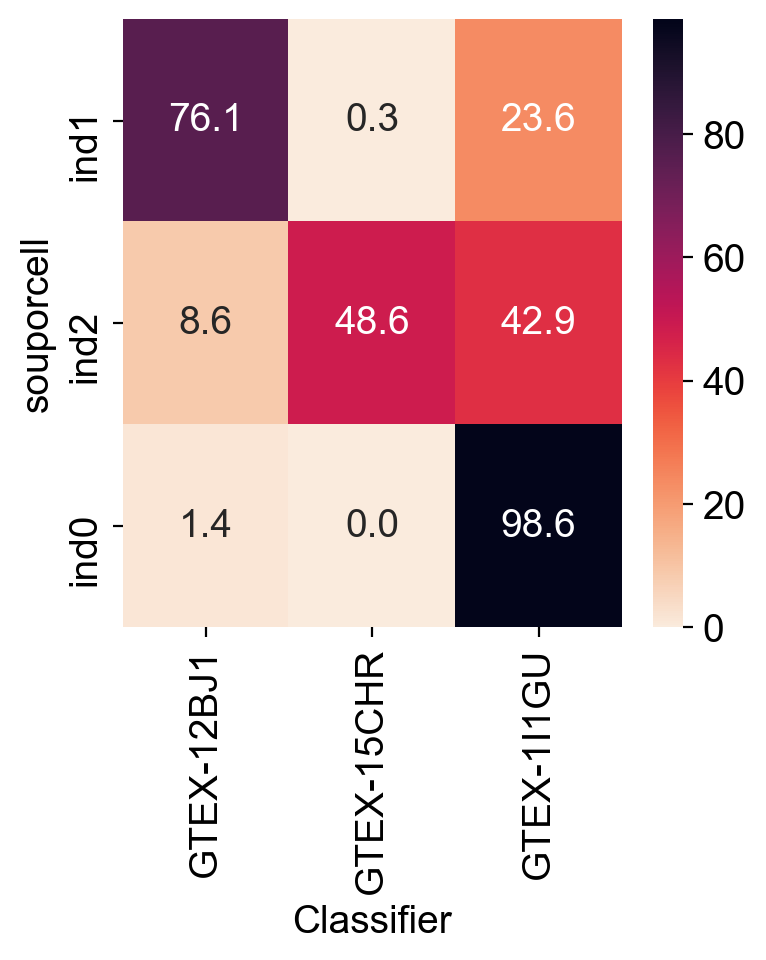

In [91]:
f = sns.heatmap(df, annot=df, fmt='.1f', cmap='rocket_r')
f.figure.savefig('figures/figure-s1-6-R.pdf', bbox_inches='tight')

## Prostate TST

### Unpooled

In [92]:
ad_prostate_tst = ad_all[(ad_all.obs.tissue == 'prostate') & (ad_all.obs.prep == 'TST') & (ad_all.obs['Participant ID'] != 'GTEX-1HSMQ')].copy()

ad_prostate_tst.X = ad_prostate_tst.layers['counts'].copy()

sc.pp.normalize_total(ad_prostate_tst, target_sum=10000)
sc.pp.log1p(ad_prostate_tst)

sc.pp.pca(ad_prostate_tst)
sc.pp.neighbors(ad_prostate_tst)
sc.tl.umap(ad_prostate_tst)

ad_prostate_tst

AnnData object with n_obs × n_vars = 6495 × 33694
    obs: 'n_genes', 'fpr', 'tissue', 'prep', 'individual', 'nGenes', 'nUMIs', 'PercentMito', 'PercentRibo', 'Age_bin', 'Sex', 'Sample ID', 'Participant ID', 'Container', 'Sample ID short', 'RIN score from PAXgene tissue Aliquot', 'RIN score from Frozen tissue Aliquot', 'Age', 'BMI', 'Race/Ethnicity', 'Autolysis Score', 'Sample Ischemic Time (mins)', 'Tissue Site Detail', 'scrublet', 'scrublet_score', 'barcode', 'batch', 'n_counts', 'tissue-individual-prep', 'Broad cell type', 'Granular cell type', 'batch_triplet', 'introns', 'junctions', 'exons', 'sense', 'antisense', 'intergenic', 'batch-barcode', 'exon_ratio', 'intron_ratio', 'junction_ratio', 'log10_nUMIs', 'leiden', 'leiden_tissue', 'Tissue composition', 'Cell types level 2', 'Cell types level 3', 'Broad cell type numbers', 'Broad cell type (numbers)', 'Tissue', 'channel', 'ischemic_time', 'Participant_ID', 'Sample_ID'
    var: 'gene_ids', 'Chromosome', 'Source', 'Start', 'End', 'St

### Pooled

In [93]:
ad_prostate_tst_p = sc.read_10x_h5('pool_prostate_tst_out_FPR_0.1_filtered.h5')
sc.pp.filter_cells(ad_prostate_tst_p, min_genes=200)
sc.pp.filter_cells(ad_prostate_tst_p, max_genes=5000)
sc.pp.filter_cells(ad_prostate_tst_p, min_counts=400)

ad_prostate_tst_p.var_names_make_unique()
ad_prostate_tst_p = ad_prostate_tst_p[:, ad_prostate_tst.var_names.tolist()].copy()
ad_prostate_tst_p.layers['counts'] = ad_prostate_tst_p.X.copy()
ad_prostate_tst_p.obs['log10_n_umis'] = np.log10(ad_prostate_tst_p.obs.n_counts)

sc.pp.normalize_total(ad_prostate_tst_p, target_sum=10000)
sc.pp.log1p(ad_prostate_tst_p)

sc.pp.pca(ad_prostate_tst_p)
sc.pp.neighbors(ad_prostate_tst_p)
sc.tl.umap(ad_prostate_tst_p)
sc.tl.leiden(ad_prostate_tst_p)

ad_prostate_tst_p.layers['scaled'] = ad_prostate_tst_p.X.copy()
sc.pp.scale(ad_prostate_tst_p, layer='scaled')

ad_prostate_tst_p

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 1414 × 33694
    obs: 'n_genes', 'n_counts', 'log10_n_umis', 'leiden'
    var: 'gene_ids', 'mean', 'std'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'scaled'
    obsp: 'distances', 'connectivities'

In [94]:
df = sc.pp.highly_variable_genes(ad_prostate_tst, n_top_genes=2500, flavor='seurat_v3', inplace=False, layer='counts')
hvgs = df.index[df.highly_variable]

df = sc.pp.highly_variable_genes(ad_prostate_tst_p, n_top_genes=2500, flavor='seurat_v3', inplace=False, layer='counts')
hvgs_p = df.index[df.highly_variable]

In [95]:
hvgs = sorted(list(set(hvgs) & set(hvgs_p)))
#hvgs.remove('ELL2')
len(hvgs)

1244

## Doublet calling

In [96]:
scr = Scrublet(ad_prostate_tst_p.layers['counts'])

scores, scrublets = scr.scrub_doublets(n_prin_comps=50, log_transform=True)
ad_prostate_tst_p.obs['scrublet_score'] = scores
ad_prostate_tst_p.obs['scrublet'] = scrublets.astype(str)

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.59
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.0%
Elapsed time: 0.8 seconds


## Read souporcell results

In [97]:
souporcell = pd.read_table('prostate_tst_souporcell.tsv', index_col=0)
souporcell.index.name = None

<AxesSubplot:>

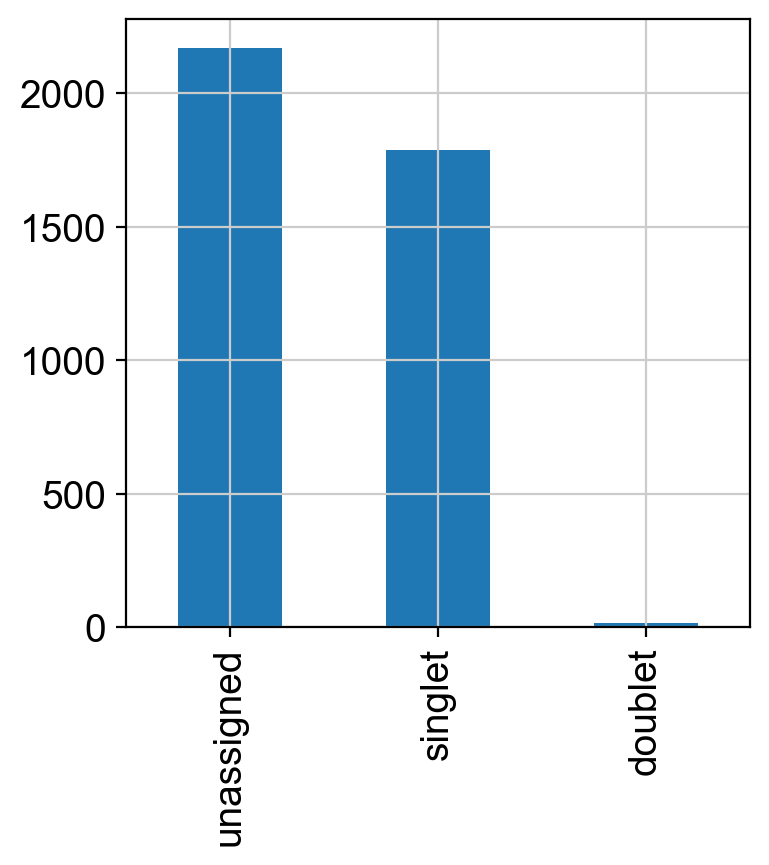

In [98]:
souporcell.status.value_counts().plot(kind='bar')

In [99]:
ad_prostate_tst_p.obs['souporcell_status'] = souporcell.status
ad_prostate_tst_p.obs['souporcell_assignment'] = souporcell.assignment
ad_prostate_tst_p.obs['souporcell_status_ind'] = [f'ind{a}' if s == 'singlet' else s for s, a in zip(ad_prostate_tst_p.obs['souporcell_status'], ad_prostate_tst_p.obs['souporcell_assignment'])]

ad_prostate_tst_p.obs['XIST+'] = (ad_prostate_tst_p.obs_vector('XIST') != 0).astype(str)

<AxesSubplot:>

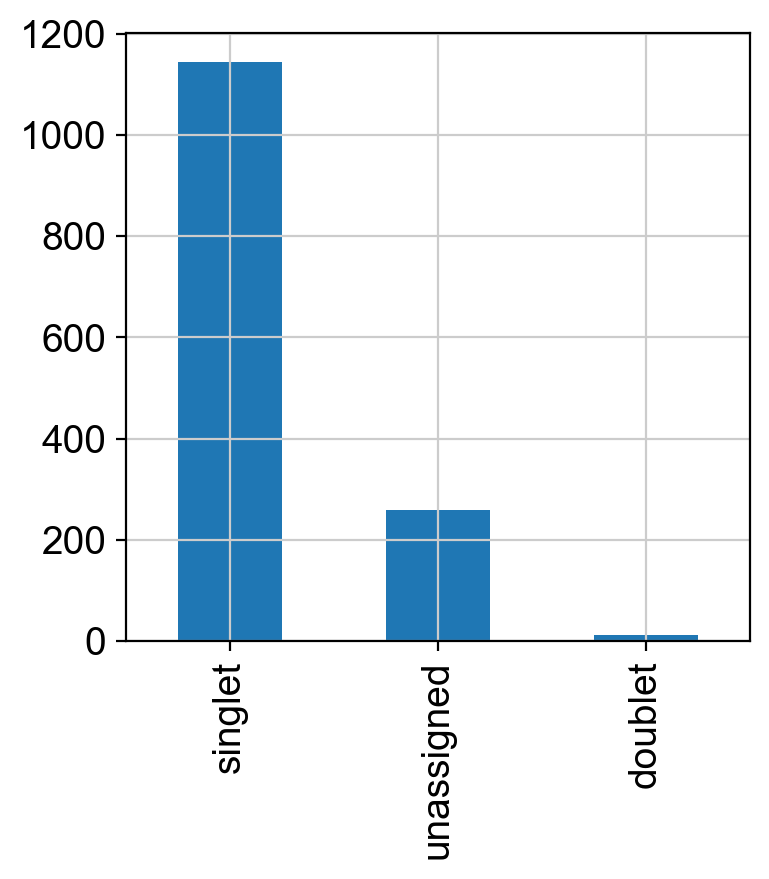

In [100]:
ad_prostate_tst_p.obs['souporcell_status'].value_counts().plot(kind='bar')

In [101]:
ad_prostate_tst_p.obs.souporcell_status.value_counts(normalize=True)

singlet       0.809052
unassigned    0.182461
doublet       0.008487
Name: souporcell_status, dtype: float64

In [102]:
ad_prostate_tst_p.obs['scrublet'].value_counts(normalize=True)

False    1.0
Name: scrublet, dtype: float64

... storing 'scrublet' as categorical
... storing 'souporcell_status' as categorical
... storing 'souporcell_assignment' as categorical
... storing 'souporcell_status_ind' as categorical
... storing 'XIST+' as categorical


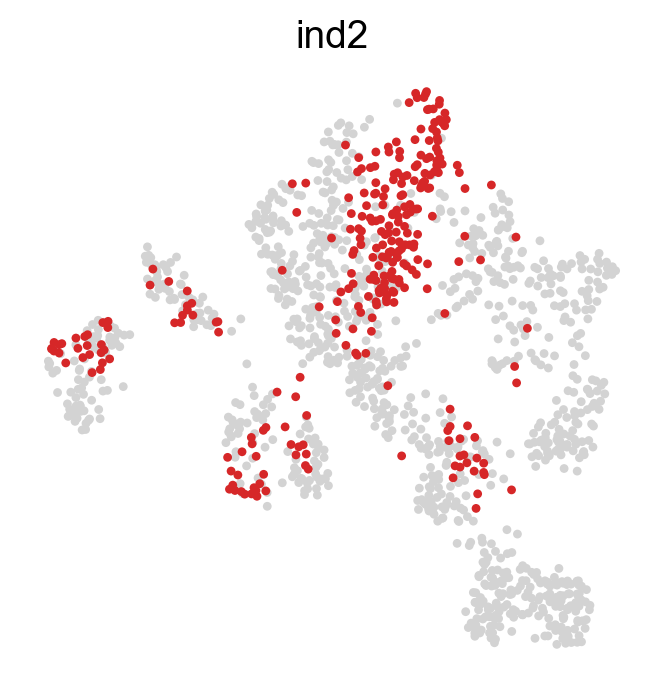

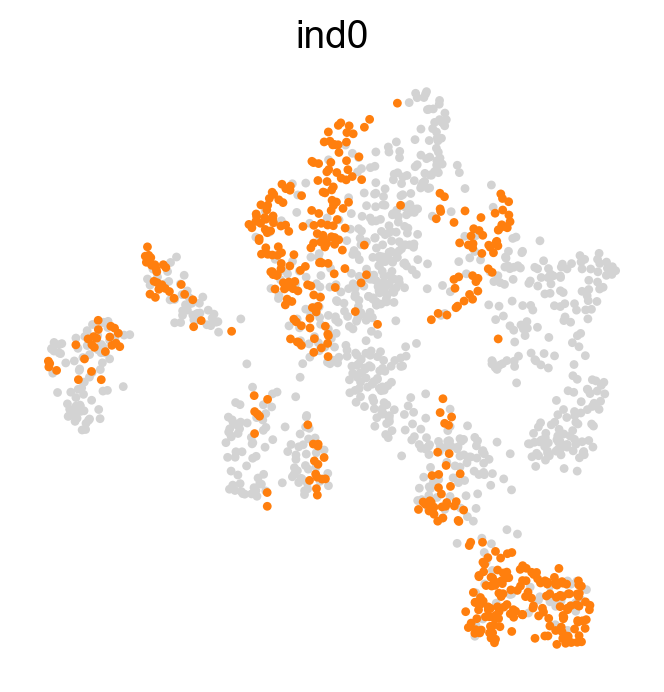

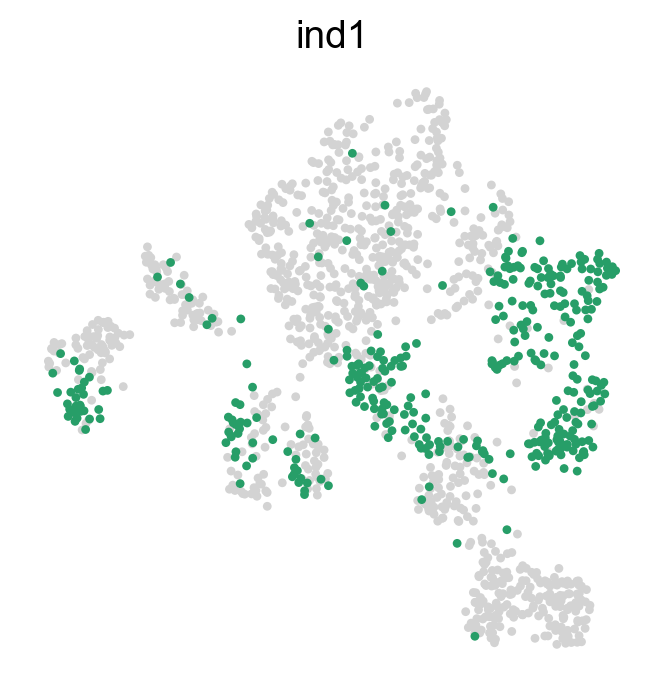

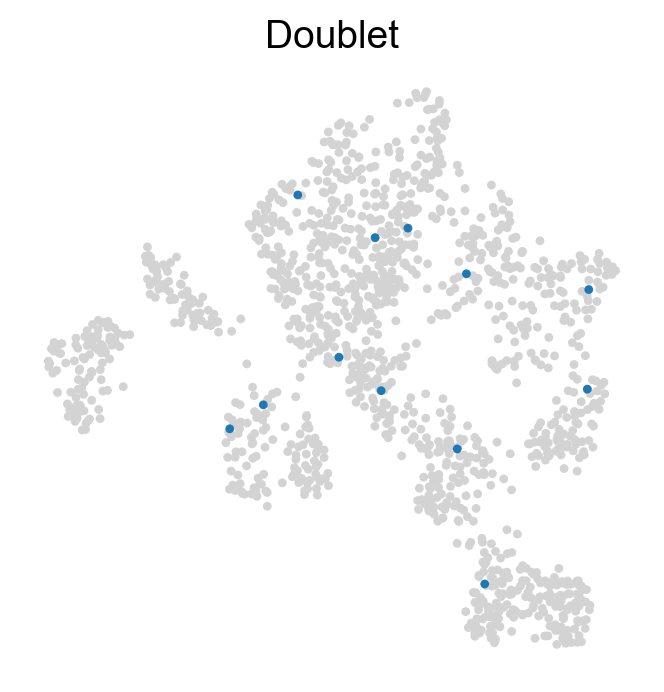

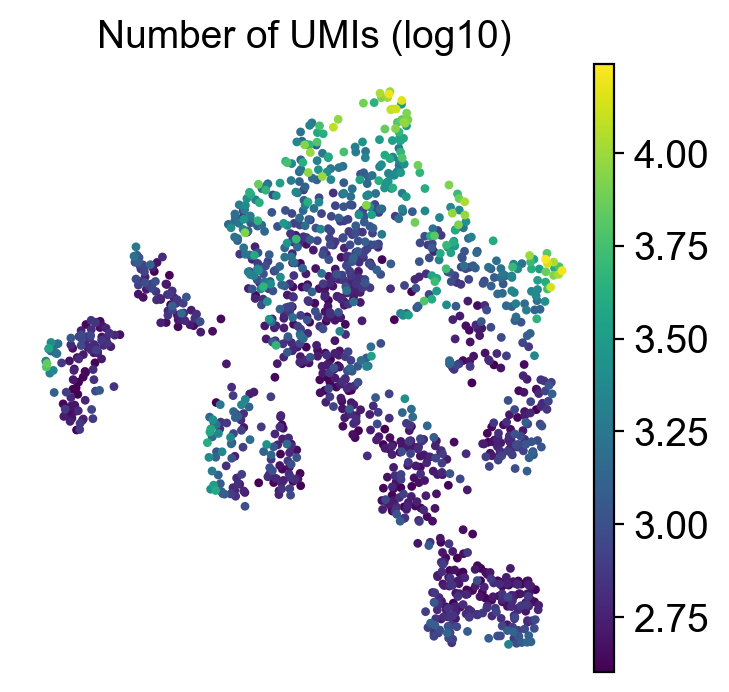

In [103]:
sc.pl.umap(ad_prostate_tst_p, color=['souporcell_status_ind'], groups='ind2', legend_loc='none', title='ind2', frameon=False, size=40, save='-figure-s1-6-S1.pdf')
sc.pl.umap(ad_prostate_tst_p, color=['souporcell_status_ind'], groups='ind0', legend_loc='none', title='ind0', frameon=False, size=40, save='-figure-s1-6-S2.pdf')
sc.pl.umap(ad_prostate_tst_p, color=['souporcell_status_ind'], groups='ind1', legend_loc='none', title='ind1', frameon=False, size=40, save='-figure-s1-6-S3.pdf')
sc.pl.umap(ad_prostate_tst_p, color=['souporcell_status_ind'], groups='doublet', legend_loc='none', title='Doublet', frameon=False, size=40, save='-figure-s1-6-T.pdf')
sc.pl.umap(ad_prostate_tst_p, color='log10_n_umis', frameon=False, size=40, title='Number of UMIs (log10)', save='-figure-s1-6-U.pdf')


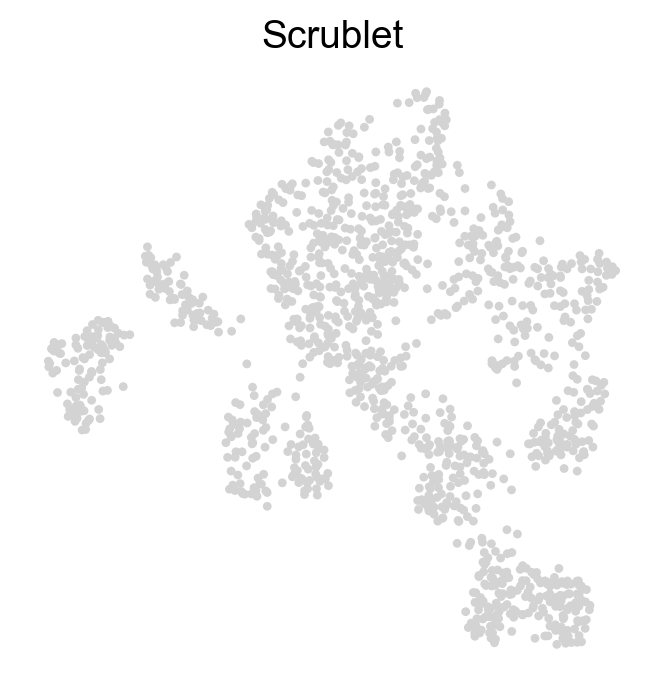

In [104]:
ad_prostate_tst_p.uns['scrublet_colors'] = ['tab:blue','tab:blue']
sc.pl.umap(ad_prostate_tst_p, color='scrublet', frameon=False, save='-figure-s1-6-W.pdf', size=40, groups=['True'], legend_loc='none', title='Scrublet')

## Predict individual labels

In [105]:
%%time

model_lr = LogisticRegression(max_iter=500, penalty='l2', solver='liblinear', C=0.001, class_weight='balanced')
model_lr.fit(ad_prostate_tst[:, hvgs].X, ad_prostate_tst.obs['Participant ID'])

CPU times: user 343 ms, sys: 3.94 ms, total: 347 ms
Wall time: 345 ms


LogisticRegression(C=0.001, class_weight='balanced', max_iter=500,
                   solver='liblinear')

In [106]:
model_lr.classes_

array(['GTEX-12BJ1', 'GTEX-15CHR', 'GTEX-1I1GU'], dtype=object)

## Plot model prediction probabilities

In [110]:
ad_prostate_tst_p.obs['individual_predicted_lr'] = model_lr.predict(ad_prostate_tst_p[:, hvgs].X)

ad_prostate_tst_p.obs['individual_predicted_lr'] = ['unknown' if p<0.6 else l for p, l in zip(model_lr.predict_proba(ad_prostate_tst_p[:, hvgs].X).max(1), ad_prostate_tst_p.obs['individual_predicted_lr'])]

ad_prostate_tst_p.obs['individual_predicted_lr_prob_GTEX-12BJ1'] = model_lr.predict_proba(ad_prostate_tst_p[:, hvgs].X).max(1)
ad_prostate_tst_p.obs['individual_predicted_lr_prob_GTEX-12BJ1'].loc[ad_prostate_tst_p.obs.individual_predicted_lr != 'GTEX-12BJ1'] = np.nan

ad_prostate_tst_p.obs['individual_predicted_lr_prob_GTEX-15CHR'] = model_lr.predict_proba(ad_prostate_tst_p[:, hvgs].X).max(1)
ad_prostate_tst_p.obs['individual_predicted_lr_prob_GTEX-15CHR'].loc[ad_prostate_tst_p.obs.individual_predicted_lr != 'GTEX-15CHR'] = np.nan

ad_prostate_tst_p.obs['individual_predicted_lr_prob_GTEX-1I1GU'] = model_lr.predict_proba(ad_prostate_tst_p[:, hvgs].X).max(1)
ad_prostate_tst_p.obs['individual_predicted_lr_prob_GTEX-1I1GU'].loc[ad_prostate_tst_p.obs.individual_predicted_lr != 'GTEX-1I1GU'] = np.nan

/home/gokcen/.miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


... storing 'individual_predicted_lr' as categorical


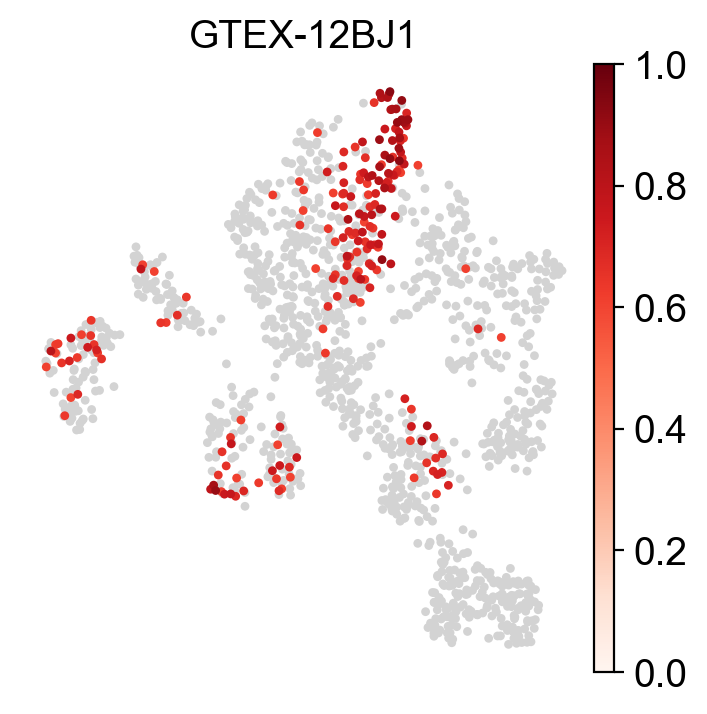

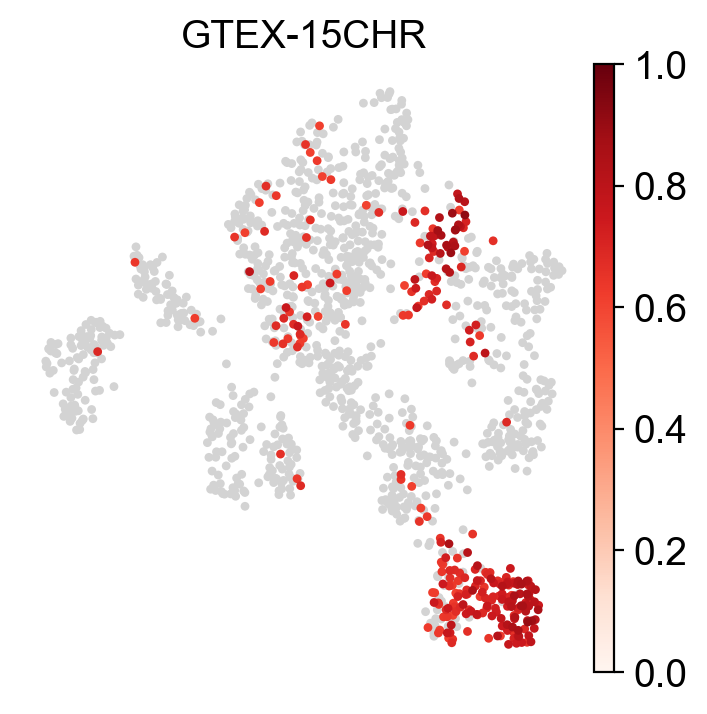

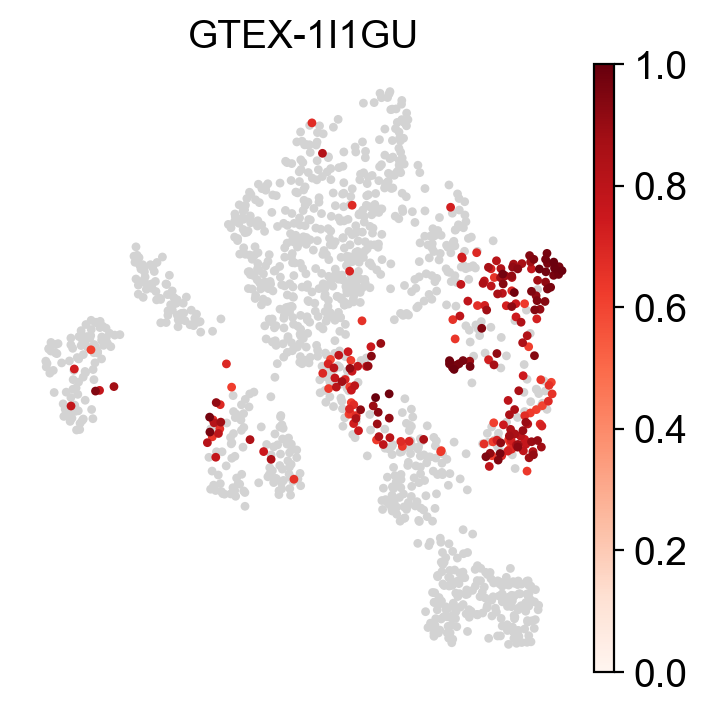

In [111]:
sc.pl.umap(ad_prostate_tst_p, color=['individual_predicted_lr_prob_GTEX-12BJ1'], legend_loc='none', title='GTEX-12BJ1', frameon=False, cmap='Reds', vmin=0., vmax=1., size=40, save='-figure-s1-6-V1.pdf')
sc.pl.umap(ad_prostate_tst_p, color=['individual_predicted_lr_prob_GTEX-15CHR'], legend_loc='none', title='GTEX-15CHR', frameon=False, cmap='Reds', vmin=0., vmax=1., size=40, save='-figure-s1-6-V2.pdf')
sc.pl.umap(ad_prostate_tst_p, color=['individual_predicted_lr_prob_GTEX-1I1GU'], legend_loc='none', title='GTEX-1I1GU', frameon=False, cmap='Reds', vmin=0., vmax=1., size=40, save='-figure-s1-6-V3.pdf')

## Concordance plots

In [112]:
balanced_accuracy_score(ad_prostate_tst_p.obs['souporcell_status_ind'] == 'doublet', ad_prostate_tst_p.obs.scrublet == 'True')

0.5

In [113]:
df = pd.crosstab(ad_prostate_tst_p.obs['souporcell_status_ind'], ad_prostate_tst_p.obs['individual_predicted_lr'])
df.index.name = 'souporcell'
df.columns.name = 'Classifier'
df = df.loc[['ind2', 'ind0', 'ind1'], ['GTEX-12BJ1', 'GTEX-15CHR', 'GTEX-1I1GU', ]]

print(np.diag(df.values).sum() / df.sum().sum())

df = (df.T/df.sum(1)).T * 100

0.9242424242424242


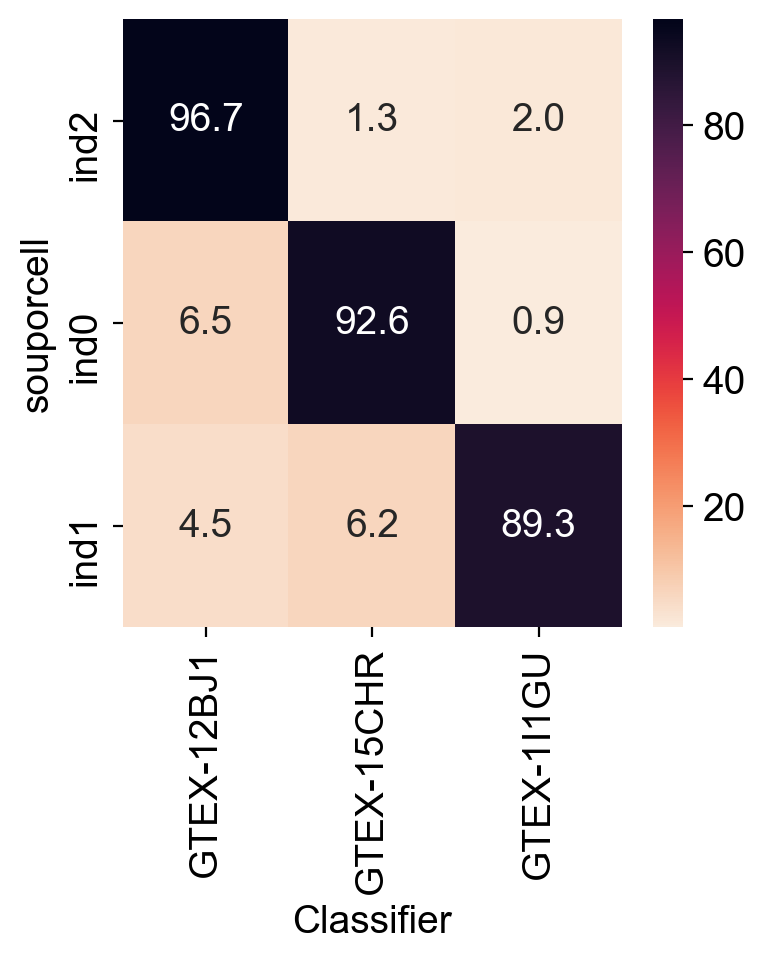

In [114]:
f = sns.heatmap(df, annot=df, fmt='.1f', cmap='rocket_r')

f.figure.savefig('figures/figure-s1-6-X.pdf', bbox_inches='tight')